# Setup

In [1]:
# Imports

import polars as pl
import duckdb
import numpy as np
import os
import math
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from tqdm.notebook import tqdm  # needs `ipywidgets` package

colormap = sns.cm.rocket
tab20 = cm.tab20

In [2]:
# Paths
project_dir = Path("/data/teamgdansk/mwaleron/carmen-analysis")




data_dir = project_dir.joinpath("data")
figures_dir = project_dir.joinpath("figures")
temp_dir = project_dir.joinpath("temp")

figures_gen_dir = figures_dir.joinpath("script-generated")
fig6panela = figures_gen_dir.joinpath("Insight-into-mutation-immune-visibility-in-15-highest-incidence-cancers.pdf")
fig6panelb = figures_gen_dir.joinpath("TQ-Insight-into-mutation-immune-visibility-in-15-highest-incidence-cancers.pdf")
fig6panelc = figures_gen_dir.joinpath("top20_recurrent_mutations.pdf")
fig6paneld = figures_gen_dir.joinpath("top20_visible_out_of_top50.pdf")

figures_main_dir = figures_gen_dir.joinpath("main-panels")
figures_supp_dir = figures_gen_dir.joinpath("supplementary")

data_subs_dir = data_dir.joinpath("subsidiary-files")
data_pub_dir = data_dir.joinpath("to-be-published")

cosmic_data_dir = data_subs_dir.joinpath("COSMIC")
cosmic_genome_screening_file = cosmic_data_dir.joinpath("Cosmic_GenomeScreensMutant_v99_GRCh38.tsv")
cosmic_classification_file = cosmic_data_dir.joinpath("Cosmic_Classification_v99_GRCh38.tsv")

oncokb_list_file = data_subs_dir.joinpath("cancerGeneList.tsv")

gendode_data_dir = data_subs_dir.joinpath("GENCODE")
gencodev39_stripped = gendode_data_dir.joinpath("gencode.v39.annotation.stripped.versions.parquet")
gene_stats_file = data_subs_dir.joinpath("per_gene_stats.parquet")

contig_scaffold_list_file = data_pub_dir.joinpath("scaff_all_expanded.tsv")
contig_peptide_list_file = data_pub_dir.joinpath("contig_unique_peptide_list.tsv")
contig_hotspot_score_file = data_subs_dir.joinpath("sorted_normalized_contig_score.parquet")
contig_hotspot_score_top_quadrant_file = data_subs_dir.joinpath("contigs_top_quadrant_by_peptides_coverage.parquet")

exon_ranges_in_contigs_file = data_subs_dir.joinpath("evenbiggerjoin_cause_its_exons_not_just_genes_v2_just_the_contig_genes.parquet")

cosmic_somatics_overlap_with_contigs_file = data_subs_dir.joinpath("cosmic_somatics_overlap_with_contigs.parquet")
cosmic_somatics_overlap_with_top_quadrant_file = data_subs_dir.joinpath("cosmic_somatics_overlap_with_tq.parquet")
cosmic_mutations_in_contigs_semi_anti_file_B = data_subs_dir.joinpath("contig_cosmic_mutations.parquet")
cosmic_mutations_in_contigs_semi_anti_file_B_compliment = data_subs_dir.joinpath("non_contig_cosmic_mutations.parquet")
cosmic_mutations_in_top_quadrant_semi_anti_file_B = data_subs_dir.joinpath("tq_cosmic_mutations.parquet")
cosmic_mutations_in_top_quadrant_semi_anti_file_B_compliment = data_subs_dir.joinpath("non_tq_cosmic_mutations.parquet")

main_samples_file = data_dir.joinpath("main-output-table-1.tsv")
main_samples_file_2 = data_dir.joinpath("main-output-table-2.tsv")
main_samples_file_3 = data_subs_dir.joinpath("emilia_umap_with_ids.parquet")

All the file reads for this stage of analysis.

In [3]:
cosmic_somatics = pl.read_csv(
    cosmic_genome_screening_file, 
    separator='\t')
cosmic_classification = pl.read_csv(
    cosmic_classification_file, 
    separator='\t')
cosmic_classification = cosmic_classification.with_columns(
    HISTOLOGY=pl.col("PRIMARY_HISTOLOGY")+ pl.lit("_|_") + pl.col("PRIMARY_SITE"))
contig_scaffold_list = pl.read_csv(
    contig_scaffold_list_file,
    separator='\t')
panelgenes = pl.read_csv(
    oncokb_list_file,
    separator="\t")
mutations_in_contigs_res = pl.read_parquet(cosmic_somatics_overlap_with_contigs_file)
# only count the mutations that produce a change on the protein level
setB = pl.read_parquet(cosmic_mutations_in_contigs_semi_anti_file_B)\
        .filter(pl.col("MUTATION_AA")!="p.?", 
                ~pl.col("MUTATION_AA").str.ends_with("="))
non_contig_mutations = pl.read_parquet(cosmic_mutations_in_contigs_semi_anti_file_B_compliment)\
                        .filter(pl.col("MUTATION_AA")!="p.?", 
                                ~pl.col("MUTATION_AA").str.ends_with("="))
                        
gencodev39 = pl.read_parquet(gencodev39_stripped)
justgenes = gencodev39.filter(pl.col("feature") == "gene", pl.col("gene_type")=="protein_coding")
panelgenes_but_with_gencode_columns = panelgenes.join(justgenes, left_on="Hugo Symbol", right_on="gene_name")

# Panel [removed] and intermediate files generation

Here we are generating the mutation lists taking into account their occurence within / outside contigs, and splitting them into the 15 cancers with highest incidence according to https://ecis.jrc.ec.europa.eu/explorer.php?$0-0$1-ACA$2-All$4-1,2$3-All$6-0,85$5-2022,2022$7-7$CEstByCancer$X0_8-3$CEstRelativeCanc$X1_8-3$X1_9-AE27$CEstBySexByCancer$X2_8-3$X2_-1-1 and an "Other" group, and filtering them to match the nomenclature with the cited list.

In [4]:
mutations_in_contigs_from_top_15_cancers = setB.join(cosmic_classification.with_columns(
                                PRIMARY_SITE = 
                                    pl.when(pl.col("PRIMARY_SITE")=="haematopoietic_and_lymphoid_tissue")\
                                    .then(
                                        pl.when(
                                        (pl.col("PRIMARY_HISTOLOGY")+pl.lit("_")+pl.col("HISTOLOGY_SUBTYPE_1"))\
                                        .is_in(['lymphoid_neoplasm_T_cell_prolymphocytic_leukaemia',
                                                'lymphoid_neoplasm_T_cell_large_granular_lymphocytic_leukaemia',
                                                'haematopoietic_neoplasm_polycythaemia_vera',
                                                'lymphoid_neoplasm_plasma_cell_myeloma',
                                                'lymphoid_neoplasm_NK_cell_leukaemia',
                                                'haematopoietic_neoplasm_myelofibrosis',
                                                'lymphoid_neoplasm_hairy_cell_leukaemia',
                                                'haematopoietic_neoplasm_chronic_neutrophilic_leukaemia',
                                                'haematopoietic_neoplasm_chronic_myelomonocytic_leukaemia',
                                                'haematopoietic_neoplasm_chronic_myeloid_leukaemia',
                                                'haematopoietic_neoplasm_blastic_plasmacytoid_dendritic_cell_neoplasm',
                                                'haematopoietic_neoplasm_blast_phase_chronic_myeloid_leukaemia',
                                                'lymphoid_neoplasm_B_cell_prolymphocytic_leukaemia',
                                                'lymphoid_neoplasm_adult_T_cell_lymphoma-leukaemia',
                                                'haematopoietic_neoplasm_acute_myeloid_leukaemia_therapy_related',
                                                'haematopoietic_neoplasm_acute_myeloid_leukaemia',
                                                'lymphoid_neoplasm_acute_lymphoblastic_T_cell_leukaemia',
                                                'lymphoid_neoplasm_acute_lymphoblastic_leukaemia',
                                                'lymphoid_neoplasm_acute_lymphoblastic_leukaemia',
                                                'haematopoietic_neoplasm_acute_lymphoblastic_leukaemia',
                                                'lymphoid_neoplasm_acute_lymphoblastic_B_cell_leukaemia',
                                                'haematopoietic_neoplasm_acute_leukaemia_of_ambiguous_lineage']
                                                )
                                            ).then(pl.lit("Leukaemia"))\
                                        .when((pl.col("PRIMARY_HISTOLOGY")+pl.lit("_")+pl.col("HISTOLOGY_SUBTYPE_1"))\
                                        .is_in(['lymphoid_neoplasm_primary_mediastinal_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_primary_central_nervous_system_lymphoma',
                                                'lymphoid_neoplasm_plasmacytoma',
                                                'lymphoid_neoplasm_peripheral_T_cell_lymphoma_unspecified',
                                                'lymphoid_neoplasm_NK-T_cell_lymphoma',
                                                'lymphoid_neoplasm_mycosis_fungoides-Sezary_syndrome',
                                                'lymphoid_neoplasm_marginal_zone_lymphoma',
                                                'lymphoid_neoplasm_marginal_zone_lymphoma',
                                                'lymphoid_neoplasm_mantle_cell_lymphoma',
                                                'lymphoid_neoplasm_mantle_cell_lymphoma',
                                                'lymphoid_neoplasm_malignant_histiocytosis',
                                                'lymphoid_neoplasm_gamma-delta_T_cell_lymphoma',
                                                'lymphoid_neoplasm_follicular_lymphoma',
                                                'lymphoid_neoplasm_follicular_lymphoma',
                                                'lymphoid_neoplasm_follicular_lymphoma',
                                                'lymphoid_neoplasm_follicular_lymphoma',
                                                'lymphoid_neoplasm_enteropathy_type_T_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_cutaneous_T_cell_lymphoma',
                                                'lymphoid_neoplasm_chronic_lymphocytic_leukaemia-small_lymphocytic_lymphoma',
                                                'lymphoid_neoplasm_Burkitt_lymphoma',
                                                'lymphoid_neoplasm_Burkitt_lymphoma',
                                                'lymphoid_neoplasm_Burkitt_lymphoma',
                                                'lymphoid_neoplasm_Burkitt_lymphoma',
                                                'lymphoid_neoplasm_Burkitt_lymphoma',
                                                'lymphoid_neoplasm_Burkitt_lymphoma',
                                                'lymphoid_neoplasm_breast_implant_associated_anaplastic_large_cell_lymphoma_invasive',
                                                'lymphoid_neoplasm_breast_implant_associated_anaplastic_large_cell_lymphoma_in_situ',
                                                'lymphoid_neoplasm_angioimmunoblastic_T_cell_lymphoma',
                                                'lymphoid_neoplasm_angioimmunoblastic_T_cell_lymphoma',
                                                'lymphoid_neoplasm_anaplastic_large_cell_lymphoma',
                                                'lymphoid_neoplasm_aggressive_epidermotropic_CD8+_T_cell_lymphoma']
                                                )
                                            ).then(pl.lit("Non-Hodgkin lymphoma"))\
                                        .otherwise(pl.col("PRIMARY_SITE")))\
                                    .otherwise(pl.col("PRIMARY_SITE"))
                                    ),
          on="COSMIC_PHENOTYPE_ID")\
              .filter((
                        (pl.col("PRIMARY_SITE") == "prostate") |
                        (pl.col("PRIMARY_SITE") == "breast")   |
                        ((pl.col("PRIMARY_SITE") == "large_intestine") & pl.col("SITE_SUBTYPE_1").is_in(["colon", "rectum"]))  |
                        (pl.col("PRIMARY_SITE") == "lung")   |
                        ((pl.col("PRIMARY_SITE") == "urinary_tract") & (pl.col("SITE_SUBTYPE_1") == "bladder")) |
                        (pl.col("PRIMARY_SITE") == "endometrium")   |
                        ((pl.col("PRIMARY_SITE") == "skin") & (pl.col("PRIMARY_HISTOLOGY") == "malignant_melanoma"))  |
                        (pl.col("PRIMARY_SITE") == "pancreas")   |
                        (pl.col("PRIMARY_SITE") == "Non-Hodgkin lymphoma") |
                        (pl.col("PRIMARY_SITE") == "kidney")   |
                        (pl.col("PRIMARY_SITE") == "ovary")   |
                        (pl.col("PRIMARY_SITE") == "stomach")   |
                        (pl.col("PRIMARY_SITE") == "Leukaemia")   |
                        (pl.col("PRIMARY_SITE") == "cervix")   |
                        (pl.col("PRIMARY_SITE") == "liver")))

In [5]:
mutations_outside_contigs_from_top_15_cancers = non_contig_mutations.join(cosmic_classification.with_columns(
                                PRIMARY_SITE = 
                                    pl.when(pl.col("PRIMARY_SITE")=="haematopoietic_and_lymphoid_tissue")\
                                    .then(
                                        pl.when(
                                        (pl.col("PRIMARY_HISTOLOGY")+pl.lit("_")+pl.col("HISTOLOGY_SUBTYPE_1"))\
                                        .is_in(['lymphoid_neoplasm_T_cell_prolymphocytic_leukaemia',
                                                'lymphoid_neoplasm_T_cell_large_granular_lymphocytic_leukaemia',
                                                'haematopoietic_neoplasm_polycythaemia_vera',
                                                'lymphoid_neoplasm_plasma_cell_myeloma',
                                                'lymphoid_neoplasm_NK_cell_leukaemia',
                                                'haematopoietic_neoplasm_myelofibrosis',
                                                'lymphoid_neoplasm_hairy_cell_leukaemia',
                                                'haematopoietic_neoplasm_chronic_neutrophilic_leukaemia',
                                                'haematopoietic_neoplasm_chronic_myelomonocytic_leukaemia',
                                                'haematopoietic_neoplasm_chronic_myeloid_leukaemia',
                                                'haematopoietic_neoplasm_blastic_plasmacytoid_dendritic_cell_neoplasm',
                                                'haematopoietic_neoplasm_blast_phase_chronic_myeloid_leukaemia',
                                                'lymphoid_neoplasm_B_cell_prolymphocytic_leukaemia',
                                                'lymphoid_neoplasm_adult_T_cell_lymphoma-leukaemia',
                                                'haematopoietic_neoplasm_acute_myeloid_leukaemia_therapy_related',
                                                'haematopoietic_neoplasm_acute_myeloid_leukaemia',
                                                'lymphoid_neoplasm_acute_lymphoblastic_T_cell_leukaemia',
                                                'lymphoid_neoplasm_acute_lymphoblastic_leukaemia',
                                                'lymphoid_neoplasm_acute_lymphoblastic_leukaemia',
                                                'haematopoietic_neoplasm_acute_lymphoblastic_leukaemia',
                                                'lymphoid_neoplasm_acute_lymphoblastic_B_cell_leukaemia',
                                                'haematopoietic_neoplasm_acute_leukaemia_of_ambiguous_lineage']
                                                )
                                            ).then(pl.lit("Leukaemia"))\
                                        .when((pl.col("PRIMARY_HISTOLOGY")+pl.lit("_")+pl.col("HISTOLOGY_SUBTYPE_1"))\
                                        .is_in(['lymphoid_neoplasm_primary_mediastinal_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_primary_central_nervous_system_lymphoma',
                                                'lymphoid_neoplasm_plasmacytoma',
                                                'lymphoid_neoplasm_peripheral_T_cell_lymphoma_unspecified',
                                                'lymphoid_neoplasm_NK-T_cell_lymphoma',
                                                'lymphoid_neoplasm_mycosis_fungoides-Sezary_syndrome',
                                                'lymphoid_neoplasm_marginal_zone_lymphoma',
                                                'lymphoid_neoplasm_marginal_zone_lymphoma',
                                                'lymphoid_neoplasm_mantle_cell_lymphoma',
                                                'lymphoid_neoplasm_mantle_cell_lymphoma',
                                                'lymphoid_neoplasm_malignant_histiocytosis',
                                                'lymphoid_neoplasm_gamma-delta_T_cell_lymphoma',
                                                'lymphoid_neoplasm_follicular_lymphoma',
                                                'lymphoid_neoplasm_follicular_lymphoma',
                                                'lymphoid_neoplasm_follicular_lymphoma',
                                                'lymphoid_neoplasm_follicular_lymphoma',
                                                'lymphoid_neoplasm_enteropathy_type_T_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_cutaneous_T_cell_lymphoma',
                                                'lymphoid_neoplasm_chronic_lymphocytic_leukaemia-small_lymphocytic_lymphoma',
                                                'lymphoid_neoplasm_Burkitt_lymphoma',
                                                'lymphoid_neoplasm_Burkitt_lymphoma',
                                                'lymphoid_neoplasm_Burkitt_lymphoma',
                                                'lymphoid_neoplasm_Burkitt_lymphoma',
                                                'lymphoid_neoplasm_Burkitt_lymphoma',
                                                'lymphoid_neoplasm_Burkitt_lymphoma',
                                                'lymphoid_neoplasm_breast_implant_associated_anaplastic_large_cell_lymphoma_invasive',
                                                'lymphoid_neoplasm_breast_implant_associated_anaplastic_large_cell_lymphoma_in_situ',
                                                'lymphoid_neoplasm_angioimmunoblastic_T_cell_lymphoma',
                                                'lymphoid_neoplasm_angioimmunoblastic_T_cell_lymphoma',
                                                'lymphoid_neoplasm_anaplastic_large_cell_lymphoma',
                                                'lymphoid_neoplasm_aggressive_epidermotropic_CD8+_T_cell_lymphoma']
                                                )
                                            ).then(pl.lit("Non-Hodgkin lymphoma"))\
                                        .otherwise(pl.col("PRIMARY_SITE")))\
                                    .otherwise(pl.col("PRIMARY_SITE"))
                                    ),
          on="COSMIC_PHENOTYPE_ID")\
              .filter((
                        (pl.col("PRIMARY_SITE") == "prostate") |
                        (pl.col("PRIMARY_SITE") == "breast")   |
                        ((pl.col("PRIMARY_SITE") == "large_intestine") & pl.col("SITE_SUBTYPE_1").is_in(["colon", "rectum"]))  |
                        (pl.col("PRIMARY_SITE") == "lung")   |
                        ((pl.col("PRIMARY_SITE") == "urinary_tract") & (pl.col("SITE_SUBTYPE_1") == "bladder")) |
                        (pl.col("PRIMARY_SITE") == "endometrium")   |
                        ((pl.col("PRIMARY_SITE") == "skin") & (pl.col("PRIMARY_HISTOLOGY") == "malignant_melanoma"))  |
                        (pl.col("PRIMARY_SITE") == "pancreas")   |
                        (pl.col("PRIMARY_SITE") == "Non-Hodgkin lymphoma") |
                        (pl.col("PRIMARY_SITE") == "kidney")   |
                        (pl.col("PRIMARY_SITE") == "ovary")   |
                        (pl.col("PRIMARY_SITE") == "stomach")   |
                        (pl.col("PRIMARY_SITE") == "Leukaemia")   |
                        (pl.col("PRIMARY_SITE") == "cervix")   |
                        (pl.col("PRIMARY_SITE") == "liver")))

## Join-contigs

In [23]:
mutcount_join4 = mutations_in_contigs_from_top_15_cancers.group_by("PRIMARY_SITE").agg(
    mutations_visible = pl.col("GENOMIC_MUTATION_ID").unique().len()
).join(mutations_outside_contigs_from_top_15_cancers.group_by("PRIMARY_SITE").agg(
    mutations_not_presented = pl.col("GENOMIC_MUTATION_ID").unique().len()
), on=["PRIMARY_SITE"], how="outer")
mutcount_join4 = mutcount_join4.with_columns(\
    PRIMARY_SITE = pl.when(pl.col("PRIMARY_SITE").is_not_null()).then(pl.col("PRIMARY_SITE")).otherwise(pl.col("PRIMARY_SITE_right"))
).with_columns(
    percent_visible = pl.col("mutations_visible") / (pl.col("mutations_visible") + pl.col("mutations_not_presented"))
)

/tmp/ipykernel_1925381/2748672675.py:1: DeprecationWarning: Use of `how='outer'` should be replaced with `how='full'`.
  mutcount_join4 = mutations_in_contigs_from_top_15_cancers.group_by("PRIMARY_SITE").agg(


In [7]:
kangur = mutations_outside_contigs_from_top_15_cancers.unique(["PRIMARY_SITE","GENOMIC_MUTATION_ID"]).group_by("PRIMARY_SITE").agg(
    mutations_visible = pl.col("GENOMIC_MUTATION_ID").unique().len(),
    genes = pl.col("GENE_SYMBOL").value_counts()
).drop("mutations_visible"
).rename({"genes":"not_displayed_per_gene"}
)

In [8]:
pingwin = mutations_in_contigs_from_top_15_cancers.unique(["PRIMARY_SITE","GENOMIC_MUTATION_ID"]).group_by("PRIMARY_SITE").agg(
    mutations_visible = pl.col("GENOMIC_MUTATION_ID").unique().len(),
    genes = pl.col("GENE_SYMBOL").value_counts()
).drop("mutations_visible"
).rename({"genes":"visible_per_gene"}
)

In [9]:
per_gene_mutation_count_list2 = \
    pingwin.explode("visible_per_gene").unnest("visible_per_gene").rename({"count":"visible_per_gene"})\
        .join(kangur.explode("not_displayed_per_gene").unnest("not_displayed_per_gene").rename({"count":"not_displayed_per_gene"}), 
            on=["PRIMARY_SITE","GENE_SYMBOL"],
            how="outer")\
        .with_columns(
            PRIMARY_SITE = pl.when(pl.col("PRIMARY_SITE").is_not_null())\
                                .then(pl.col("PRIMARY_SITE"))\
                                .otherwise(pl.col("PRIMARY_SITE_right")),          
            GENE_SYMBOL = pl.when(pl.col("GENE_SYMBOL").is_not_null())\
                                .then(pl.col("GENE_SYMBOL"))\
                                .otherwise(pl.col("GENE_SYMBOL_right")))\
        .drop("PRIMARY_SITE_right","GENE_SYMBOL_right")\
        .fill_null(0)\
        .with_columns(
            NUMBER_OF_MUTATIONS = (pl.col("visible_per_gene")+pl.col("not_displayed_per_gene")))\
        .with_columns(
            PERCENT_DISPLAYED   = (pl.col("visible_per_gene") / pl.col("NUMBER_OF_MUTATIONS")))\
        .filter(pl.col("GENE_SYMBOL").is_in(panelgenes["Hugo Symbol"]))

/tmp/ipykernel_1626633/802649746.py:2: DeprecationWarning: Use of `how='outer'` should be replaced with `how='full'`.
  pingwin.explode("visible_per_gene").unnest("visible_per_gene").rename({"count":"visible_per_gene"})\


In [10]:
genestats = pl.read_parquet(gene_stats_file)

In [11]:
# we remove those three specific gene IDs because they appear twice (occur both on X and Y chromosome), but we only map them to the Y chromosome in pogo
panelgene_stats = panelgenes_but_with_gencode_columns.join(genestats.filter(~pl.col("gene_id").is_in(["ENSG00000205755","ENSG00000182162","ENSG00000169093"])), on="gene_id").select("Hugo Symbol", "exon_percentage","exon_coverage","non_exon_coverage")

In [12]:
per_gene_mut_count_list_in_top_15_cancers = per_gene_mutation_count_list2.filter(
    pl.col("PRIMARY_SITE").is_in(
        ["prostate",
         "breast",
         "large_intestine", #colorectum
         "lung",
         "urinary_tract",
         "endometrium",
         "skin", #separate melanoma and carcinoma?
         "pancreas",
         "Non-Hodgkin lymphoma",
         "kidney",
         "ovary",
         "Leukaemia",
         "stomach",
         "liver",
         "cervix"])
    ).group_by("GENE_SYMBOL")\
        .sum()\
        .with_columns(
            NUMBER_OF_MUTATIONS = (pl.col("visible_per_gene")+pl.col("not_displayed_per_gene")))\
        .with_columns(
            PERCENT_DISPLAYED   = (pl.col("visible_per_gene") / pl.col("NUMBER_OF_MUTATIONS")))\
    .join(
        genestats.filter(~pl.col("gene_id").is_in(["ENSG00000205755","ENSG00000182162","ENSG00000169093"])).join(justgenes.select("gene_name","gene_id", length = pl.col("end") - pl.col("start")),on="gene_id").with_columns(pl.col("gene_name").alias("GENE_SYMBOL"), exon_length = pl.col("length") * pl.col("exon_percentage") * 0.01),
        on="GENE_SYMBOL")\
    .with_columns(
        MUTATIONS_PER_AA = pl.col("NUMBER_OF_MUTATIONS") / pl.col("exon_length"))\
    .sort("MUTATIONS_PER_AA", descending=True)

In [13]:
# here we take only the top 95% of genes - to possibly filter out the cases which have very low/high "visibility" due to very small amount of mutations
len = per_gene_mut_count_list_in_top_15_cancers["NUMBER_OF_MUTATIONS"].len()
per_gene_mut_count_list_in_top_15_cancers = per_gene_mut_count_list_in_top_15_cancers.sort("NUMBER_OF_MUTATIONS", descending=True).head(math.floor(0.95*len))

In [14]:
top10mutations = per_gene_mut_count_list_in_top_15_cancers.sort("MUTATIONS_PER_AA", descending=True).head(10)["GENE_SYMBOL"]
top10visible = per_gene_mut_count_list_in_top_15_cancers.sort("PERCENT_DISPLAYED", descending=True).head(10)["GENE_SYMBOL"]
top10hidden  = per_gene_mut_count_list_in_top_15_cancers.sort("PERCENT_DISPLAYED", descending=True).tail(10)["GENE_SYMBOL"]

In [15]:
fixed_order = pl.Enum(["prostate",
         "breast",
         "large_intestine", #colorectum
         "lung",
         "urinary_tract",
         "endometrium",
         "skin", #separate melanoma and carcinoma?
         "pancreas",
         "Non-Hodgkin lymphoma",
         "kidney",
         "ovary",
         "stomach",
         "Leukaemia",
         "cervix",
         "liver"])

/tmp/ipykernel_1626633/1979094462.py:58: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  genevismatrix.filter(pl.col("GENE_SYMBOL").is_in(top10visible)).sort(pl.col("GENE_SYMBOL").cast(pl.Enum(top10visible))).join(panelgene_stats, left_on="GENE_SYMBOL", right_on="Hugo Symbol", how="left")["exon_coverage"]
/tmp/ipykernel_1626633/1979094462.py:75: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  genevismatrix.filter(pl.col("GENE_SYMBOL").is_in(top10hidden)).sort(pl.col("GENE_SYMBOL").cast(pl.Enum(top10hidden))).join(panelgene_stats, left_on="GENE_SYMBOL", right_on="Hugo Symbol", how="left")["exon_coverage"]
/tmp/ipykernel_1626633/1979094462.py:108: DeprecationWarning: The default coalesce behavior of l

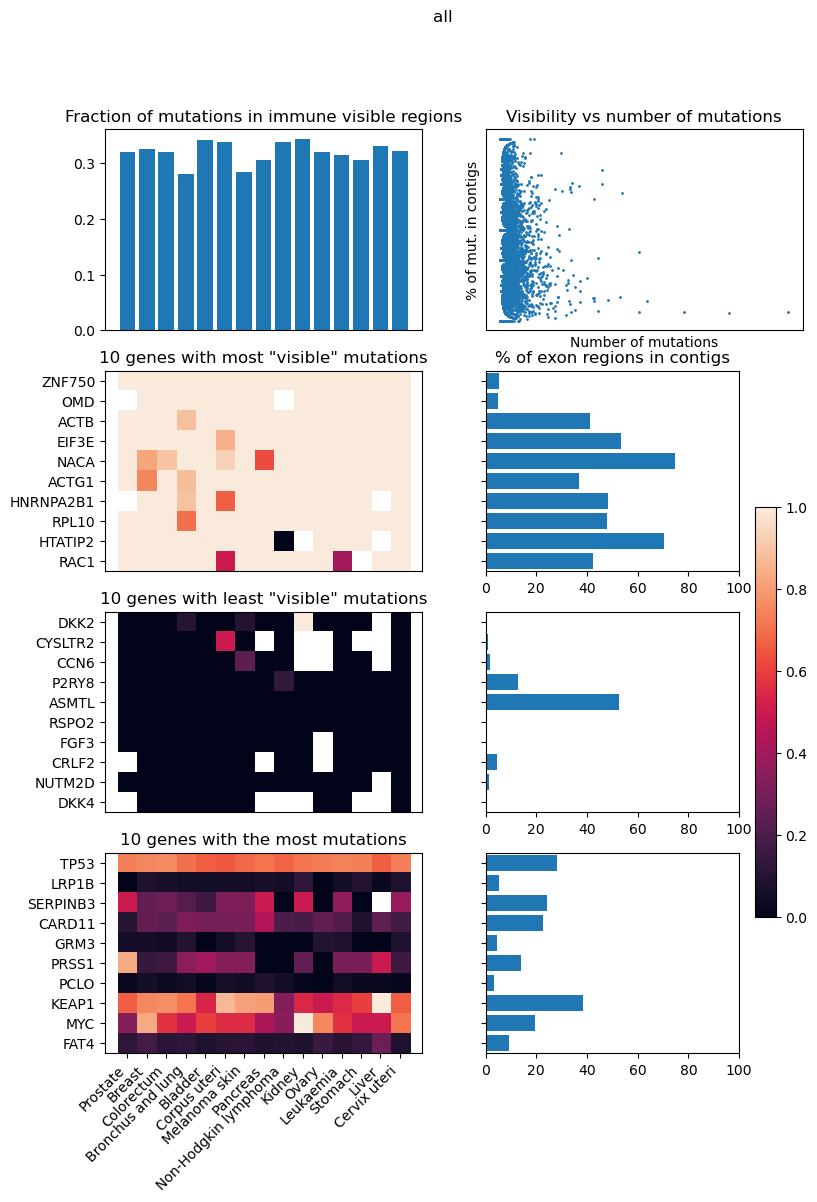

In [16]:
fig = plt.figure(figsize=(9,12))
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42
plt.rcParams["svg.fonttype"] = "none"
mutations_per_gene = mutcount_join4.drop("PRIMARY_HISTOLOGY_right").join(per_gene_mutation_count_list2.drop("PRIMARY_HISTOLOGY_right").filter(
    pl.col("PRIMARY_SITE").is_in(
        ["prostate",
         "breast",
         "large_intestine", #colorectum
         "lung",
         "urinary_tract",
         "endometrium",
         "skin", #separate melanoma and carcinoma?
         "pancreas",
         "Non-Hodgkin lymphoma",
         "kidney",
         "ovary",
         "Leukaemia",
         "stomach",
         "liver",
         "cervix"])
    ), on=["PRIMARY_SITE"]).sort(pl.col("PRIMARY_SITE").cast(fixed_order))
mutations_per_site = mutcount_join4.filter(
    pl.col("PRIMARY_SITE").is_in(
        ["prostate",
         "breast",
         "large_intestine", #colorectum
         "lung",
         "urinary_tract",
         "endometrium",
         "skin", #separate melanoma and carcinoma?
         "pancreas",
         "Non-Hodgkin lymphoma",
         "kidney",
         "ovary",
         "Leukaemia",
         "stomach",
         "liver",
         "cervix"])).sort(pl.col("PRIMARY_SITE").cast(fixed_order))
ax1 = plt.subplot(421)
ax1.bar(mutations_per_site["PRIMARY_SITE"], mutations_per_site["percent_visible"])
ax1.set_xticklabels([])
ax1.set_xticks([])
ax1.set_title("Fraction of mutations in immune visible regions")
save_this_yscale_for_fig_2 = ax1.get_ylim()
genevismatrix = mutations_per_gene.pivot(columns="PRIMARY_SITE", index="GENE_SYMBOL", values="PERCENT_DISPLAYED")
ax = plt.subplot(423)
im = ax.imshow(genevismatrix.filter(pl.col("GENE_SYMBOL").is_in(top10visible)).sort(pl.col("GENE_SYMBOL").cast(pl.Enum(top10visible))).select(pl.col(mutations_per_site["PRIMARY_SITE"])).to_numpy(),aspect="auto", label="percent visible", cmap=colormap)
ax.set_yticks(genevismatrix.filter(pl.col("GENE_SYMBOL").is_in(top10visible)).sort(pl.col("GENE_SYMBOL").cast(pl.Enum(top10visible)))["GENE_SYMBOL"].cast(pl.Categorical()).to_physical())
ax.set_yticklabels(genevismatrix.filter(pl.col("GENE_SYMBOL").is_in(top10visible)).sort(pl.col("GENE_SYMBOL").cast(pl.Enum(top10visible)))["GENE_SYMBOL"])
ax.set_xlim(ax1.get_xlim())
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_title("10 genes with most \"visible\" mutations")
ax_exon = plt.subplot(424)
ax_exon.barh(
    genevismatrix.filter(pl.col("GENE_SYMBOL").is_in(top10visible)).sort(pl.col("GENE_SYMBOL").cast(pl.Enum(top10visible)))["GENE_SYMBOL"],
    genevismatrix.filter(pl.col("GENE_SYMBOL").is_in(top10visible)).sort(pl.col("GENE_SYMBOL").cast(pl.Enum(top10visible))).join(panelgene_stats, left_on="GENE_SYMBOL", right_on="Hugo Symbol", how="left")["exon_coverage"]
    )
ax_exon.set_xlim(0,100)
ax_exon.set_ylim(ax.get_ylim())
ax_exon.set_yticklabels([])
ax_exon.set_title("% of exon regions in contigs")
ax3 = plt.subplot(425)
im3 = ax3.imshow(genevismatrix.filter(pl.col("GENE_SYMBOL").is_in(top10hidden)).sort(pl.col("GENE_SYMBOL").cast(pl.Enum(top10hidden))).select(pl.col(mutations_per_site["PRIMARY_SITE"])).to_numpy(),aspect="auto", label="percent visible", cmap=colormap)
ax3.set_yticks(genevismatrix.filter(pl.col("GENE_SYMBOL").is_in(top10hidden)).sort(pl.col("GENE_SYMBOL").cast(pl.Enum(top10hidden)))["GENE_SYMBOL"].cast(pl.Categorical()).to_physical())
ax3.set_yticklabels(genevismatrix.filter(pl.col("GENE_SYMBOL").is_in(top10hidden)).sort(pl.col("GENE_SYMBOL").cast(pl.Enum(top10hidden)))["GENE_SYMBOL"])
ax3.set_xlim(ax1.get_xlim())
ax3.set_xticklabels([])
ax3.set_xticks([])
ax3.set_title("10 genes with least \"visible\" mutations")
ax3_exon = plt.subplot(426)
ax3_exon.barh(
    genevismatrix.filter(pl.col("GENE_SYMBOL").is_in(top10hidden)).sort(pl.col("GENE_SYMBOL").cast(pl.Enum(top10hidden)))["GENE_SYMBOL"],
    genevismatrix.filter(pl.col("GENE_SYMBOL").is_in(top10hidden)).sort(pl.col("GENE_SYMBOL").cast(pl.Enum(top10hidden))).join(panelgene_stats, left_on="GENE_SYMBOL", right_on="Hugo Symbol", how="left")["exon_coverage"]
    )
ax3_exon.set_xlim(0,100)
ax3_exon.set_ylim(ax3.get_ylim())
ax3_exon.set_yticklabels([])
ax5 = plt.subplot(427)
im5 = ax5.imshow(genevismatrix.filter(pl.col("GENE_SYMBOL").is_in(top10mutations)).sort(pl.col("GENE_SYMBOL").cast(pl.Enum(top10mutations))).select(pl.col(mutations_per_site["PRIMARY_SITE"])).to_numpy(),aspect="auto", label="percent visible", cmap=colormap)
ax5.set_yticks(genevismatrix.filter(pl.col("GENE_SYMBOL").is_in(top10mutations)).sort(pl.col("GENE_SYMBOL").cast(pl.Enum(top10mutations)))["GENE_SYMBOL"].cast(pl.Categorical()).to_physical())
ax5.set_yticklabels(genevismatrix.filter(pl.col("GENE_SYMBOL").is_in(top10mutations)).sort(pl.col("GENE_SYMBOL").cast(pl.Enum(top10mutations)))["GENE_SYMBOL"])
ax5.set_xticks(
    range(mutations_per_site["PRIMARY_SITE"].len()),
        ["Prostate",
         "Breast",
         "Colorectum", #colorectum
         "Bronchus and lung",
         "Bladder",
         "Corpus uteri",
         "Melanoma skin", #separate melanoma and carcinoma?
         "Pancreas",
         "Non-Hodgkin lymphoma",
         "Kidney",
         "Ovary",
         "Leukaemia",
         "Stomach",
         "Liver",
         "Cervix uteri"],
        rotation=45,
        ha='right')
ax5.set_xlim(ax1.get_xlim())
ax5.set_title("10 genes with the most mutations")
ax5_exon = plt.subplot(428)
ax5_exon.barh(
    genevismatrix.filter(pl.col("GENE_SYMBOL").is_in(top10mutations)).sort(pl.col("GENE_SYMBOL").cast(pl.Enum(top10mutations)))["GENE_SYMBOL"], 
    genevismatrix.filter(pl.col("GENE_SYMBOL").is_in(top10mutations)).sort(pl.col("GENE_SYMBOL").cast(pl.Enum(top10mutations))).join(panelgene_stats, left_on="GENE_SYMBOL", right_on="Hugo Symbol", how="left")["exon_coverage"]
    )
ax5_exon.set_xlim(0,100)
ax5_exon.set_ylim(ax5.get_ylim())
ax5_exon.set_yticklabels([])
scat = plt.subplot(422)
scat.scatter(mutations_per_gene["NUMBER_OF_MUTATIONS"],mutations_per_gene["PERCENT_DISPLAYED"],s=1)
scat.set_yticklabels([])
scat.set_yticks([])
scat.set_ylabel("% of mut. in contigs")
scat.set_xticklabels([])
scat.set_xticks([])
scat.set_xlabel("Number of mutations")
scat.set_title("Visibility vs number of mutations")
fig.suptitle("all")
fig.colorbar(mappable=cm.ScalarMappable(cmap=colormap) ,ax=[ax_exon,ax3_exon,ax5_exon], shrink=0.6)
fig.savefig(fig6panela)

# Panel C

This is the same analyis done for panel C

In [18]:
panelgene_list_file = temp_dir.joinpath("pgenes.tsv")
temp_dir.joinpath("tq_stats").mkdir(parents=True, exist_ok=True)
temp_dir.joinpath("tq_exons").mkdir(parents=True, exist_ok=True)
temp_dir.joinpath("tq_nonexons").mkdir(parents=True, exist_ok=True)
pl.DataFrame(panelgenes_but_with_gencode_columns["gene_id"]).write_parquet(panelgene_list_file)

In [19]:
%%script false --no-raise-error
# run the coverage analysis just for the top quadrant contigs
# we don't really need it for all the genes so just panel genes should be fine
# recommended to parallelize this step, using your favourite tool, example would be:
# cat pgenes.tsv | parallel --bar python calculate_coverage_tq.py

# alternatively just let it run serially:
for gene in tqdm(panelgenes_but_with_gencode_columns["gene_id"]):
    os.system(f"python ./calculate_coverage_tq.py {gene}")

In [20]:
diditwork = pl.read_parquet(temp_dir.joinpath("tq_stats/*"))

In [21]:
panelgene_stats = diditwork.join(panelgenes_but_with_gencode_columns, on="gene_id").filter(~pl.col("gene_id").is_in(["ENSG00000205755","ENSG00000182162","ENSG00000169093"])).select("Hugo Symbol", "exon_percentage", "exon_coverage")

In [22]:
non_tq_mutations = pl.read_parquet(cosmic_mutations_in_top_quadrant_semi_anti_file_B_compliment)\
                        .filter(pl.col("MUTATION_AA")!="p.?", 
                                ~pl.col("MUTATION_AA").str.ends_with("="))
setBtq = pl.read_parquet(cosmic_mutations_in_top_quadrant_semi_anti_file_B)\
                        .filter(pl.col("MUTATION_AA")!="p.?", 
                                ~pl.col("MUTATION_AA").str.ends_with("="))

mutations_in_tq_from_top_15_cancers = setBtq.join(cosmic_classification.with_columns(
                                PRIMARY_SITE = 
                                    pl.when(pl.col("PRIMARY_SITE")=="haematopoietic_and_lymphoid_tissue")\
                                    .then(
                                        pl.when(
                                        (pl.col("PRIMARY_HISTOLOGY")+pl.lit("_")+pl.col("HISTOLOGY_SUBTYPE_1"))\
                                        .is_in(['lymphoid_neoplasm_T_cell_prolymphocytic_leukaemia',
                                                'lymphoid_neoplasm_T_cell_large_granular_lymphocytic_leukaemia',
                                                'haematopoietic_neoplasm_polycythaemia_vera',
                                                'lymphoid_neoplasm_plasma_cell_myeloma',
                                                'lymphoid_neoplasm_NK_cell_leukaemia',
                                                'haematopoietic_neoplasm_myelofibrosis',
                                                'lymphoid_neoplasm_hairy_cell_leukaemia',
                                                'haematopoietic_neoplasm_chronic_neutrophilic_leukaemia',
                                                'haematopoietic_neoplasm_chronic_myelomonocytic_leukaemia',
                                                'haematopoietic_neoplasm_chronic_myeloid_leukaemia',
                                                'haematopoietic_neoplasm_blastic_plasmacytoid_dendritic_cell_neoplasm',
                                                'haematopoietic_neoplasm_blast_phase_chronic_myeloid_leukaemia',
                                                'lymphoid_neoplasm_B_cell_prolymphocytic_leukaemia',
                                                'lymphoid_neoplasm_adult_T_cell_lymphoma-leukaemia',
                                                'haematopoietic_neoplasm_acute_myeloid_leukaemia_therapy_related',
                                                'haematopoietic_neoplasm_acute_myeloid_leukaemia',
                                                'lymphoid_neoplasm_acute_lymphoblastic_T_cell_leukaemia',
                                                'lymphoid_neoplasm_acute_lymphoblastic_leukaemia',
                                                'lymphoid_neoplasm_acute_lymphoblastic_leukaemia',
                                                'haematopoietic_neoplasm_acute_lymphoblastic_leukaemia',
                                                'lymphoid_neoplasm_acute_lymphoblastic_B_cell_leukaemia',
                                                'haematopoietic_neoplasm_acute_leukaemia_of_ambiguous_lineage']
                                                )
                                            ).then(pl.lit("Leukaemia"))\
                                        .when((pl.col("PRIMARY_HISTOLOGY")+pl.lit("_")+pl.col("HISTOLOGY_SUBTYPE_1"))\
                                        .is_in(['lymphoid_neoplasm_primary_mediastinal_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_primary_central_nervous_system_lymphoma',
                                                'lymphoid_neoplasm_plasmacytoma',
                                                'lymphoid_neoplasm_peripheral_T_cell_lymphoma_unspecified',
                                                'lymphoid_neoplasm_NK-T_cell_lymphoma',
                                                'lymphoid_neoplasm_mycosis_fungoides-Sezary_syndrome',
                                                'lymphoid_neoplasm_marginal_zone_lymphoma',
                                                'lymphoid_neoplasm_marginal_zone_lymphoma',
                                                'lymphoid_neoplasm_mantle_cell_lymphoma',
                                                'lymphoid_neoplasm_mantle_cell_lymphoma',
                                                'lymphoid_neoplasm_malignant_histiocytosis',
                                                'lymphoid_neoplasm_gamma-delta_T_cell_lymphoma',
                                                'lymphoid_neoplasm_follicular_lymphoma',
                                                'lymphoid_neoplasm_follicular_lymphoma',
                                                'lymphoid_neoplasm_follicular_lymphoma',
                                                'lymphoid_neoplasm_follicular_lymphoma',
                                                'lymphoid_neoplasm_enteropathy_type_T_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_cutaneous_T_cell_lymphoma',
                                                'lymphoid_neoplasm_chronic_lymphocytic_leukaemia-small_lymphocytic_lymphoma',
                                                'lymphoid_neoplasm_Burkitt_lymphoma',
                                                'lymphoid_neoplasm_Burkitt_lymphoma',
                                                'lymphoid_neoplasm_Burkitt_lymphoma',
                                                'lymphoid_neoplasm_Burkitt_lymphoma',
                                                'lymphoid_neoplasm_Burkitt_lymphoma',
                                                'lymphoid_neoplasm_Burkitt_lymphoma',
                                                'lymphoid_neoplasm_breast_implant_associated_anaplastic_large_cell_lymphoma_invasive',
                                                'lymphoid_neoplasm_breast_implant_associated_anaplastic_large_cell_lymphoma_in_situ',
                                                'lymphoid_neoplasm_angioimmunoblastic_T_cell_lymphoma',
                                                'lymphoid_neoplasm_angioimmunoblastic_T_cell_lymphoma',
                                                'lymphoid_neoplasm_anaplastic_large_cell_lymphoma',
                                                'lymphoid_neoplasm_aggressive_epidermotropic_CD8+_T_cell_lymphoma']
                                                )
                                            ).then(pl.lit("Non-Hodgkin lymphoma"))\
                                        .otherwise(pl.col("PRIMARY_SITE")))\
                                    .otherwise(pl.col("PRIMARY_SITE"))
                                    ),
          on="COSMIC_PHENOTYPE_ID")\
              .filter((
                        (pl.col("PRIMARY_SITE") == "prostate") |
                        (pl.col("PRIMARY_SITE") == "breast")   |
                        ((pl.col("PRIMARY_SITE") == "large_intestine") & pl.col("SITE_SUBTYPE_1").is_in(["colon", "rectum"]))  |
                        (pl.col("PRIMARY_SITE") == "lung")   |
                        ((pl.col("PRIMARY_SITE") == "urinary_tract") & (pl.col("SITE_SUBTYPE_1") == "bladder")) |
                        (pl.col("PRIMARY_SITE") == "endometrium")   |
                        ((pl.col("PRIMARY_SITE") == "skin") & (pl.col("PRIMARY_HISTOLOGY") == "malignant_melanoma"))  |
                        (pl.col("PRIMARY_SITE") == "pancreas")   |
                        (pl.col("PRIMARY_SITE") == "Non-Hodgkin lymphoma") |
                        (pl.col("PRIMARY_SITE") == "kidney")   |
                        (pl.col("PRIMARY_SITE") == "ovary")   |
                        (pl.col("PRIMARY_SITE") == "stomach")   |
                        (pl.col("PRIMARY_SITE") == "Leukaemia")   |
                        (pl.col("PRIMARY_SITE") == "cervix")   |
                        (pl.col("PRIMARY_SITE") == "liver")))
mutations_outside_tq_from_top_15_cancers = non_tq_mutations.join(cosmic_classification.with_columns(
                                PRIMARY_SITE = 
                                    pl.when(pl.col("PRIMARY_SITE")=="haematopoietic_and_lymphoid_tissue")\
                                    .then(
                                        pl.when(
                                        (pl.col("PRIMARY_HISTOLOGY")+pl.lit("_")+pl.col("HISTOLOGY_SUBTYPE_1"))\
                                        .is_in(['lymphoid_neoplasm_T_cell_prolymphocytic_leukaemia',
                                                'lymphoid_neoplasm_T_cell_large_granular_lymphocytic_leukaemia',
                                                'haematopoietic_neoplasm_polycythaemia_vera',
                                                'lymphoid_neoplasm_plasma_cell_myeloma',
                                                'lymphoid_neoplasm_NK_cell_leukaemia',
                                                'haematopoietic_neoplasm_myelofibrosis',
                                                'lymphoid_neoplasm_hairy_cell_leukaemia',
                                                'haematopoietic_neoplasm_chronic_neutrophilic_leukaemia',
                                                'haematopoietic_neoplasm_chronic_myelomonocytic_leukaemia',
                                                'haematopoietic_neoplasm_chronic_myeloid_leukaemia',
                                                'haematopoietic_neoplasm_blastic_plasmacytoid_dendritic_cell_neoplasm',
                                                'haematopoietic_neoplasm_blast_phase_chronic_myeloid_leukaemia',
                                                'lymphoid_neoplasm_B_cell_prolymphocytic_leukaemia',
                                                'lymphoid_neoplasm_adult_T_cell_lymphoma-leukaemia',
                                                'haematopoietic_neoplasm_acute_myeloid_leukaemia_therapy_related',
                                                'haematopoietic_neoplasm_acute_myeloid_leukaemia',
                                                'lymphoid_neoplasm_acute_lymphoblastic_T_cell_leukaemia',
                                                'lymphoid_neoplasm_acute_lymphoblastic_leukaemia',
                                                'lymphoid_neoplasm_acute_lymphoblastic_leukaemia',
                                                'haematopoietic_neoplasm_acute_lymphoblastic_leukaemia',
                                                'lymphoid_neoplasm_acute_lymphoblastic_B_cell_leukaemia',
                                                'haematopoietic_neoplasm_acute_leukaemia_of_ambiguous_lineage']
                                                )
                                            ).then(pl.lit("Leukaemia"))\
                                        .when((pl.col("PRIMARY_HISTOLOGY")+pl.lit("_")+pl.col("HISTOLOGY_SUBTYPE_1"))\
                                        .is_in(['lymphoid_neoplasm_primary_mediastinal_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_primary_central_nervous_system_lymphoma',
                                                'lymphoid_neoplasm_plasmacytoma',
                                                'lymphoid_neoplasm_peripheral_T_cell_lymphoma_unspecified',
                                                'lymphoid_neoplasm_NK-T_cell_lymphoma',
                                                'lymphoid_neoplasm_mycosis_fungoides-Sezary_syndrome',
                                                'lymphoid_neoplasm_marginal_zone_lymphoma',
                                                'lymphoid_neoplasm_marginal_zone_lymphoma',
                                                'lymphoid_neoplasm_mantle_cell_lymphoma',
                                                'lymphoid_neoplasm_mantle_cell_lymphoma',
                                                'lymphoid_neoplasm_malignant_histiocytosis',
                                                'lymphoid_neoplasm_gamma-delta_T_cell_lymphoma',
                                                'lymphoid_neoplasm_follicular_lymphoma',
                                                'lymphoid_neoplasm_follicular_lymphoma',
                                                'lymphoid_neoplasm_follicular_lymphoma',
                                                'lymphoid_neoplasm_follicular_lymphoma',
                                                'lymphoid_neoplasm_enteropathy_type_T_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_cutaneous_T_cell_lymphoma',
                                                'lymphoid_neoplasm_chronic_lymphocytic_leukaemia-small_lymphocytic_lymphoma',
                                                'lymphoid_neoplasm_Burkitt_lymphoma',
                                                'lymphoid_neoplasm_Burkitt_lymphoma',
                                                'lymphoid_neoplasm_Burkitt_lymphoma',
                                                'lymphoid_neoplasm_Burkitt_lymphoma',
                                                'lymphoid_neoplasm_Burkitt_lymphoma',
                                                'lymphoid_neoplasm_Burkitt_lymphoma',
                                                'lymphoid_neoplasm_breast_implant_associated_anaplastic_large_cell_lymphoma_invasive',
                                                'lymphoid_neoplasm_breast_implant_associated_anaplastic_large_cell_lymphoma_in_situ',
                                                'lymphoid_neoplasm_angioimmunoblastic_T_cell_lymphoma',
                                                'lymphoid_neoplasm_angioimmunoblastic_T_cell_lymphoma',
                                                'lymphoid_neoplasm_anaplastic_large_cell_lymphoma',
                                                'lymphoid_neoplasm_aggressive_epidermotropic_CD8+_T_cell_lymphoma']
                                                )
                                            ).then(pl.lit("Non-Hodgkin lymphoma"))\
                                        .otherwise(pl.col("PRIMARY_SITE")))\
                                    .otherwise(pl.col("PRIMARY_SITE"))
                                    ),
          on="COSMIC_PHENOTYPE_ID")\
              .filter((
                        (pl.col("PRIMARY_SITE") == "prostate") |
                        (pl.col("PRIMARY_SITE") == "breast")   |
                        ((pl.col("PRIMARY_SITE") == "large_intestine") & pl.col("SITE_SUBTYPE_1").is_in(["colon", "rectum"]))  |
                        (pl.col("PRIMARY_SITE") == "lung")   |
                        ((pl.col("PRIMARY_SITE") == "urinary_tract") & (pl.col("SITE_SUBTYPE_1") == "bladder")) |
                        (pl.col("PRIMARY_SITE") == "endometrium")   |
                        ((pl.col("PRIMARY_SITE") == "skin") & (pl.col("PRIMARY_HISTOLOGY") == "malignant_melanoma"))  |
                        (pl.col("PRIMARY_SITE") == "pancreas")   |
                        (pl.col("PRIMARY_SITE") == "Non-Hodgkin lymphoma") |
                        (pl.col("PRIMARY_SITE") == "kidney")   |
                        (pl.col("PRIMARY_SITE") == "ovary")   |
                        (pl.col("PRIMARY_SITE") == "stomach")   |
                        (pl.col("PRIMARY_SITE") == "Leukaemia")   |
                        (pl.col("PRIMARY_SITE") == "cervix")   |
                        (pl.col("PRIMARY_SITE") == "liver")))
mutcount_join_tq = mutations_in_tq_from_top_15_cancers.group_by("PRIMARY_SITE").agg(
    mutations_visible = pl.col("GENOMIC_MUTATION_ID").unique().len()
).join(mutations_outside_tq_from_top_15_cancers.group_by("PRIMARY_SITE").agg(
    mutations_not_presented = pl.col("GENOMIC_MUTATION_ID").unique().len()
), on=["PRIMARY_SITE"], how="outer")
mutcount_join_tq = mutcount_join_tq.with_columns(\
    PRIMARY_SITE = pl.when(pl.col("PRIMARY_SITE").is_not_null()).then(pl.col("PRIMARY_SITE")).otherwise(pl.col("PRIMARY_SITE_right"))
).with_columns(
    percent_visible = pl.col("mutations_visible") / (pl.col("mutations_visible") + pl.col("mutations_not_presented"))
)
ratatuj_poczekaj = mutations_outside_tq_from_top_15_cancers.unique(["PRIMARY_SITE","GENOMIC_MUTATION_ID"]).group_by("PRIMARY_SITE").agg(
    mutations_visible = pl.col("GENOMIC_MUTATION_ID").unique().len(),
    genes = pl.col("GENE_SYMBOL").value_counts()
).drop("mutations_visible"
).rename({"genes":"not_displayed_per_gene"}
)
chomik = mutations_in_tq_from_top_15_cancers.unique(["PRIMARY_SITE","GENOMIC_MUTATION_ID"]).group_by("PRIMARY_SITE").agg(
    mutations_visible = pl.col("GENOMIC_MUTATION_ID").unique().len(),
    genes = pl.col("GENE_SYMBOL").value_counts()
).drop("mutations_visible"
).rename({"genes":"visible_per_gene"}
)
per_gene_mutation_count_list_tq = \
    chomik.explode("visible_per_gene").unnest("visible_per_gene").rename({"count":"visible_per_gene"})\
        .join(ratatuj_poczekaj.explode("not_displayed_per_gene").unnest("not_displayed_per_gene").rename({"count":"not_displayed_per_gene"}), 
            on=["PRIMARY_SITE","GENE_SYMBOL"],
            how="outer")\
        .with_columns(
            PRIMARY_SITE = pl.when(pl.col("PRIMARY_SITE").is_not_null())\
                                .then(pl.col("PRIMARY_SITE"))\
                                .otherwise(pl.col("PRIMARY_SITE_right")),          
            GENE_SYMBOL = pl.when(pl.col("GENE_SYMBOL").is_not_null())\
                                .then(pl.col("GENE_SYMBOL"))\
                                .otherwise(pl.col("GENE_SYMBOL_right")))\
        .drop("PRIMARY_SITE_right","GENE_SYMBOL_right")\
        .fill_null(0)\
        .with_columns(
            NUMBER_OF_MUTATIONS = (pl.col("visible_per_gene")+pl.col("not_displayed_per_gene")))\
        .with_columns(
            PERCENT_DISPLAYED   = (pl.col("visible_per_gene") / pl.col("NUMBER_OF_MUTATIONS")))\
        .filter(pl.col("GENE_SYMBOL").is_in(panelgenes["Hugo Symbol"]))
per_gene_mut_count_list_in_top_15_cancers_tq = per_gene_mutation_count_list_tq.filter(
    pl.col("PRIMARY_SITE").is_in(
        ["prostate",
         "breast",
         "large_intestine", #colorectum
         "lung",
         "urinary_tract",
         "endometrium",
         "skin", #separate melanoma and carcinoma?
         "pancreas",
         "Non-Hodgkin lymphoma",
         "kidney",
         "ovary",
         "Leukaemia",
         "stomach",
         "liver",
         "cervix"])
    ).group_by("GENE_SYMBOL")\
        .sum()\
        .with_columns(
            NUMBER_OF_MUTATIONS = (pl.col("visible_per_gene")+pl.col("not_displayed_per_gene")))\
        .with_columns(
            PERCENT_DISPLAYED   = (pl.col("visible_per_gene") / pl.col("NUMBER_OF_MUTATIONS")))\
    .join(
        diditwork.filter(~pl.col("gene_id").is_in(["ENSG00000205755","ENSG00000182162","ENSG00000169093"]))\
                 .join(
                     justgenes.select(
                         "gene_name",
                         "gene_id", 
                         length = pl.col("end") - pl.col("start")),
                     on="gene_id")\
                 .with_columns(
                     pl.col("gene_name").alias("GENE_SYMBOL"), 
                     exon_length = pl.col("length") * pl.col("exon_percentage") * 0.01),
        on="GENE_SYMBOL")\
    .with_columns(
        MUTATIONS_PER_AA = pl.col("NUMBER_OF_MUTATIONS") / pl.col("exon_length"))\
    .sort("MUTATIONS_PER_AA", descending=True)
len = per_gene_mut_count_list_in_top_15_cancers_tq["NUMBER_OF_MUTATIONS"].len()
per_gene_mut_count_list_in_top_15_cancers_tq = per_gene_mut_count_list_in_top_15_cancers_tq.sort("NUMBER_OF_MUTATIONS", descending=True).head(math.floor(0.95*len))
top10mutations_tq = per_gene_mut_count_list_in_top_15_cancers_tq.sort("MUTATIONS_PER_AA", descending=True).head(10)["GENE_SYMBOL"]
top10visible_tq = per_gene_mut_count_list_in_top_15_cancers_tq.sort("PERCENT_DISPLAYED", descending=True).head(10)["GENE_SYMBOL"]
top10hidden_tq  = per_gene_mut_count_list_in_top_15_cancers_tq.sort("PERCENT_DISPLAYED", descending=True).tail(10)["GENE_SYMBOL"]

/tmp/ipykernel_1626633/1853448818.py:196: DeprecationWarning: Use of `how='outer'` should be replaced with `how='full'`.
  mutcount_join_tq = mutations_in_tq_from_top_15_cancers.group_by("PRIMARY_SITE").agg(
/tmp/ipykernel_1626633/1853448818.py:219: DeprecationWarning: Use of `how='outer'` should be replaced with `how='full'`.
  chomik.explode("visible_per_gene").unnest("visible_per_gene").rename({"count":"visible_per_gene"})\


/tmp/ipykernel_1626633/2901212847.py:59: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  genevismatrix.filter(pl.col("GENE_SYMBOL").is_in(top10visible_tq)).sort(pl.col("GENE_SYMBOL").cast(pl.Enum(top10visible_tq))).join(panelgene_stats, left_on="GENE_SYMBOL", right_on="Hugo Symbol", how="left")["exon_coverage"],
/tmp/ipykernel_1626633/2901212847.py:77: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  genevismatrix.filter(pl.col("GENE_SYMBOL").is_in(top10hidden_tq)).sort(pl.col("GENE_SYMBOL").cast(pl.Enum(top10hidden_tq))).join(panelgene_stats, left_on="GENE_SYMBOL", right_on="Hugo Symbol", how="left")["exon_coverage"],
/tmp/ipykernel_1626633/2901212847.py:111: DeprecationWarning: The default coalesce

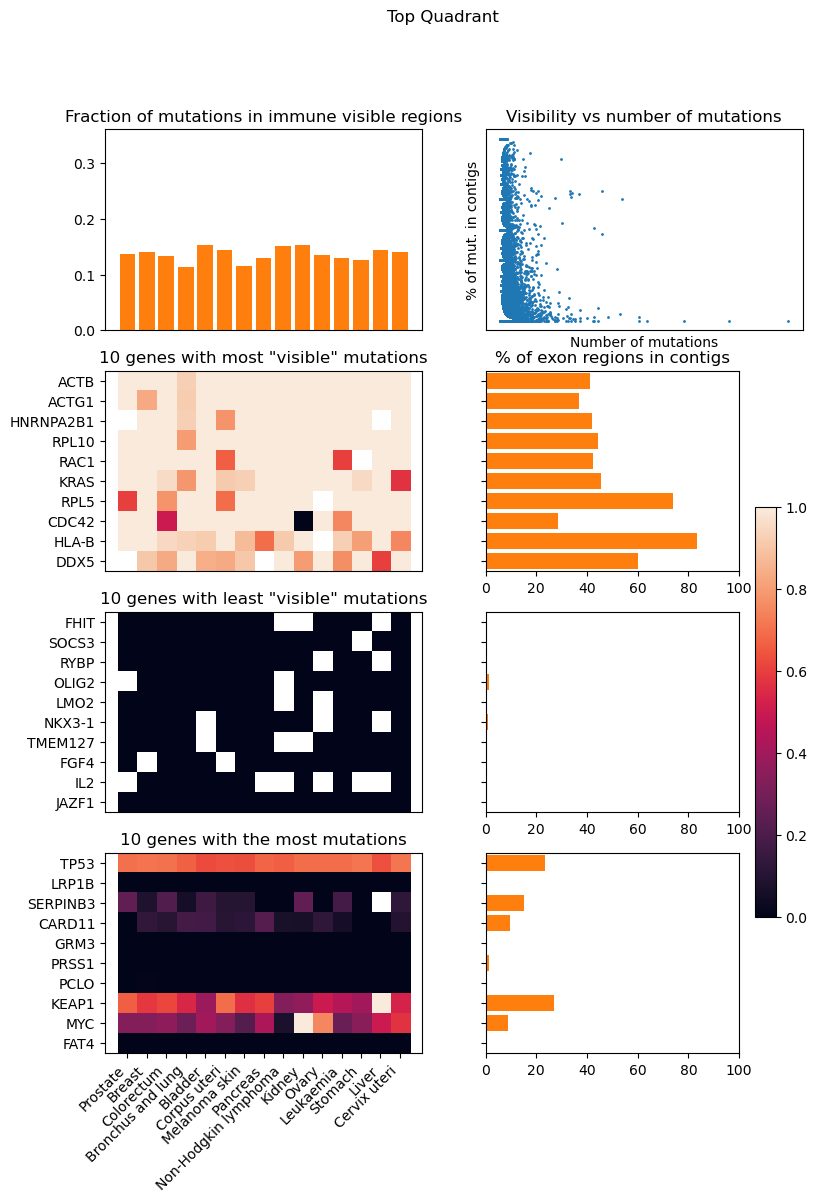

In [23]:
fig = plt.figure(figsize=(9,12))
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42
plt.rcParams["svg.fonttype"] = "none"
mutations_per_gene = mutcount_join_tq.drop("PRIMARY_HISTOLOGY_right").join(per_gene_mutation_count_list_tq.drop("PRIMARY_HISTOLOGY_right").filter(
    pl.col("PRIMARY_SITE").is_in(
        ["prostate",
         "breast",
         "large_intestine", #colorectum
         "lung",
         "urinary_tract",
         "endometrium",
         "skin", #separate melanoma and carcinoma?
         "pancreas",
         "Non-Hodgkin lymphoma",
         "kidney",
         "ovary",
         "Leukaemia",
         "stomach",
         "liver",
         "cervix"])
    ), on=["PRIMARY_SITE"]).sort(pl.col("PRIMARY_SITE").cast(fixed_order))
mutations_per_site = mutcount_join_tq.filter(
    pl.col("PRIMARY_SITE").is_in(
        ["prostate",
         "breast",
         "large_intestine", #colorectum
         "lung",
         "urinary_tract",
         "endometrium",
         "skin", #separate melanoma and carcinoma?
         "pancreas",
         "Non-Hodgkin lymphoma",
         "kidney",
         "ovary",
         "Leukaemia",
         "stomach",
         "liver",
         "cervix"])
    ).sort(pl.col("PRIMARY_SITE").cast(fixed_order))
ax1 = plt.subplot(421)
ax1.bar(mutations_per_site["PRIMARY_SITE"], mutations_per_site["percent_visible"], color="tab:orange")
ax1.set_xticklabels([])
ax1.set_xticks([])
ax1.set_title("Fraction of mutations in immune visible regions")
ax1.set_ylim(save_this_yscale_for_fig_2)
genevismatrix = mutations_per_gene.pivot(columns="PRIMARY_SITE", index="GENE_SYMBOL", values="PERCENT_DISPLAYED")
ax = plt.subplot(423)
im = ax.imshow(genevismatrix.filter(pl.col("GENE_SYMBOL").is_in(top10visible_tq)).sort(pl.col("GENE_SYMBOL").cast(pl.Enum(top10visible_tq))).select(pl.col(mutations_per_site["PRIMARY_SITE"])).to_numpy(),aspect="auto", label="percent visible", cmap = colormap)
ax.set_yticks(genevismatrix.filter(pl.col("GENE_SYMBOL").is_in(top10visible_tq)).sort(pl.col("GENE_SYMBOL").cast(pl.Enum(top10visible_tq)))["GENE_SYMBOL"].cast(pl.Categorical()).to_physical())
ax.set_yticklabels(genevismatrix.filter(pl.col("GENE_SYMBOL").is_in(top10visible_tq)).sort(pl.col("GENE_SYMBOL").cast(pl.Enum(top10visible_tq)))["GENE_SYMBOL"])
ax.set_xlim(ax1.get_xlim())
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_title("10 genes with most \"visible\" mutations")
ax_exon = plt.subplot(424)
ax_exon.barh(
    genevismatrix.filter(pl.col("GENE_SYMBOL").is_in(top10visible_tq)).sort(pl.col("GENE_SYMBOL").cast(pl.Enum(top10visible_tq)))["GENE_SYMBOL"],
    genevismatrix.filter(pl.col("GENE_SYMBOL").is_in(top10visible_tq)).sort(pl.col("GENE_SYMBOL").cast(pl.Enum(top10visible_tq))).join(panelgene_stats, left_on="GENE_SYMBOL", right_on="Hugo Symbol", how="left")["exon_coverage"],
    color="tab:orange"
    )
ax_exon.set_xlim(0,100)
ax_exon.set_ylim(ax.get_ylim())
ax_exon.set_yticklabels([])
ax_exon.set_title("% of exon regions in contigs")
ax3 = plt.subplot(425)
im3 = ax3.imshow(genevismatrix.filter(pl.col("GENE_SYMBOL").is_in(top10hidden_tq)).sort(pl.col("GENE_SYMBOL").cast(pl.Enum(top10hidden_tq))).select(pl.col(mutations_per_site["PRIMARY_SITE"])).to_numpy(),aspect="auto", label="percent visible", cmap = colormap)
ax3.set_yticks(genevismatrix.filter(pl.col("GENE_SYMBOL").is_in(top10hidden_tq)).sort(pl.col("GENE_SYMBOL").cast(pl.Enum(top10hidden_tq)))["GENE_SYMBOL"].cast(pl.Categorical()).to_physical())
ax3.set_yticklabels(genevismatrix.filter(pl.col("GENE_SYMBOL").is_in(top10hidden_tq)).sort(pl.col("GENE_SYMBOL").cast(pl.Enum(top10hidden_tq)))["GENE_SYMBOL"])
ax3.set_xlim(ax1.get_xlim())
ax3.set_xticklabels([])
ax3.set_xticks([])
ax3.set_title("10 genes with least \"visible\" mutations")
ax3_exon = plt.subplot(426)
ax3_exon.barh(
    genevismatrix.filter(pl.col("GENE_SYMBOL").is_in(top10hidden_tq)).sort(pl.col("GENE_SYMBOL").cast(pl.Enum(top10hidden_tq)))["GENE_SYMBOL"],
    genevismatrix.filter(pl.col("GENE_SYMBOL").is_in(top10hidden_tq)).sort(pl.col("GENE_SYMBOL").cast(pl.Enum(top10hidden_tq))).join(panelgene_stats, left_on="GENE_SYMBOL", right_on="Hugo Symbol", how="left")["exon_coverage"],
    color="tab:orange"
    )
ax3_exon.set_xlim(0,100)
ax3_exon.set_ylim(ax3.get_ylim())
ax3_exon.set_yticklabels([])
ax5 = plt.subplot(427)
im5 = ax5.imshow(genevismatrix.filter(pl.col("GENE_SYMBOL").is_in(top10mutations_tq)).sort(pl.col("GENE_SYMBOL").cast(pl.Enum(top10mutations_tq))).select(pl.col(mutations_per_site["PRIMARY_SITE"])).to_numpy(),aspect="auto", label="percent visible", cmap = colormap)
ax5.set_yticks(genevismatrix.filter(pl.col("GENE_SYMBOL").is_in(top10mutations_tq)).sort(pl.col("GENE_SYMBOL").cast(pl.Enum(top10mutations_tq)))["GENE_SYMBOL"].cast(pl.Categorical()).to_physical())
ax5.set_yticklabels(genevismatrix.filter(pl.col("GENE_SYMBOL").is_in(top10mutations_tq)).sort(pl.col("GENE_SYMBOL").cast(pl.Enum(top10mutations_tq)))["GENE_SYMBOL"])
ax5.set_xticks(
    range(mutations_per_site["PRIMARY_SITE"].len()),
        ["Prostate",
         "Breast",
         "Colorectum", #colorectum
         "Bronchus and lung",
         "Bladder",
         "Corpus uteri",
         "Melanoma skin", #separate melanoma and carcinoma?
         "Pancreas",
         "Non-Hodgkin lymphoma",
         "Kidney",
         "Ovary",
         "Leukaemia",
         "Stomach",
         "Liver",
         "Cervix uteri"],
        rotation=45,
        ha='right')
ax5.set_xlim(ax1.get_xlim())
ax5.set_title("10 genes with the most mutations")
ax5_exon = plt.subplot(428)
ax5_exon.barh(
    genevismatrix.filter(pl.col("GENE_SYMBOL").is_in(top10mutations_tq)).sort(pl.col("GENE_SYMBOL").cast(pl.Enum(top10mutations_tq)))["GENE_SYMBOL"], 
    genevismatrix.filter(pl.col("GENE_SYMBOL").is_in(top10mutations_tq)).sort(pl.col("GENE_SYMBOL").cast(pl.Enum(top10mutations_tq))).join(panelgene_stats, left_on="GENE_SYMBOL", right_on="Hugo Symbol", how="left")["exon_coverage"],
    color="tab:orange"
    )
ax5_exon.set_xlim(0,100)
ax5_exon.set_ylim(ax5.get_ylim())
ax5_exon.set_yticklabels([])
scat = plt.subplot(422)
scat.scatter(mutations_per_gene["NUMBER_OF_MUTATIONS"],mutations_per_gene["PERCENT_DISPLAYED"],s=1)
scat.set_yticklabels([])
scat.set_yticks([])
scat.set_ylabel("% of mut. in contigs")
scat.set_xticklabels([])
scat.set_xticks([])
scat.set_xlabel("Number of mutations")
scat.set_title("Visibility vs number of mutations")
fig.suptitle("Top Quadrant")
fig.colorbar(mappable=cm.ScalarMappable(cmap=colormap) ,ax=[ax_exon,ax3_exon,ax5_exon], shrink=0.6)
fig.savefig(fig6panelb)

# Panel A top half

/tmp/ipykernel_1136148/201785692.py:183: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  stats = stacked_barplot_matrix\


<Figure size 900x1200 with 0 Axes>

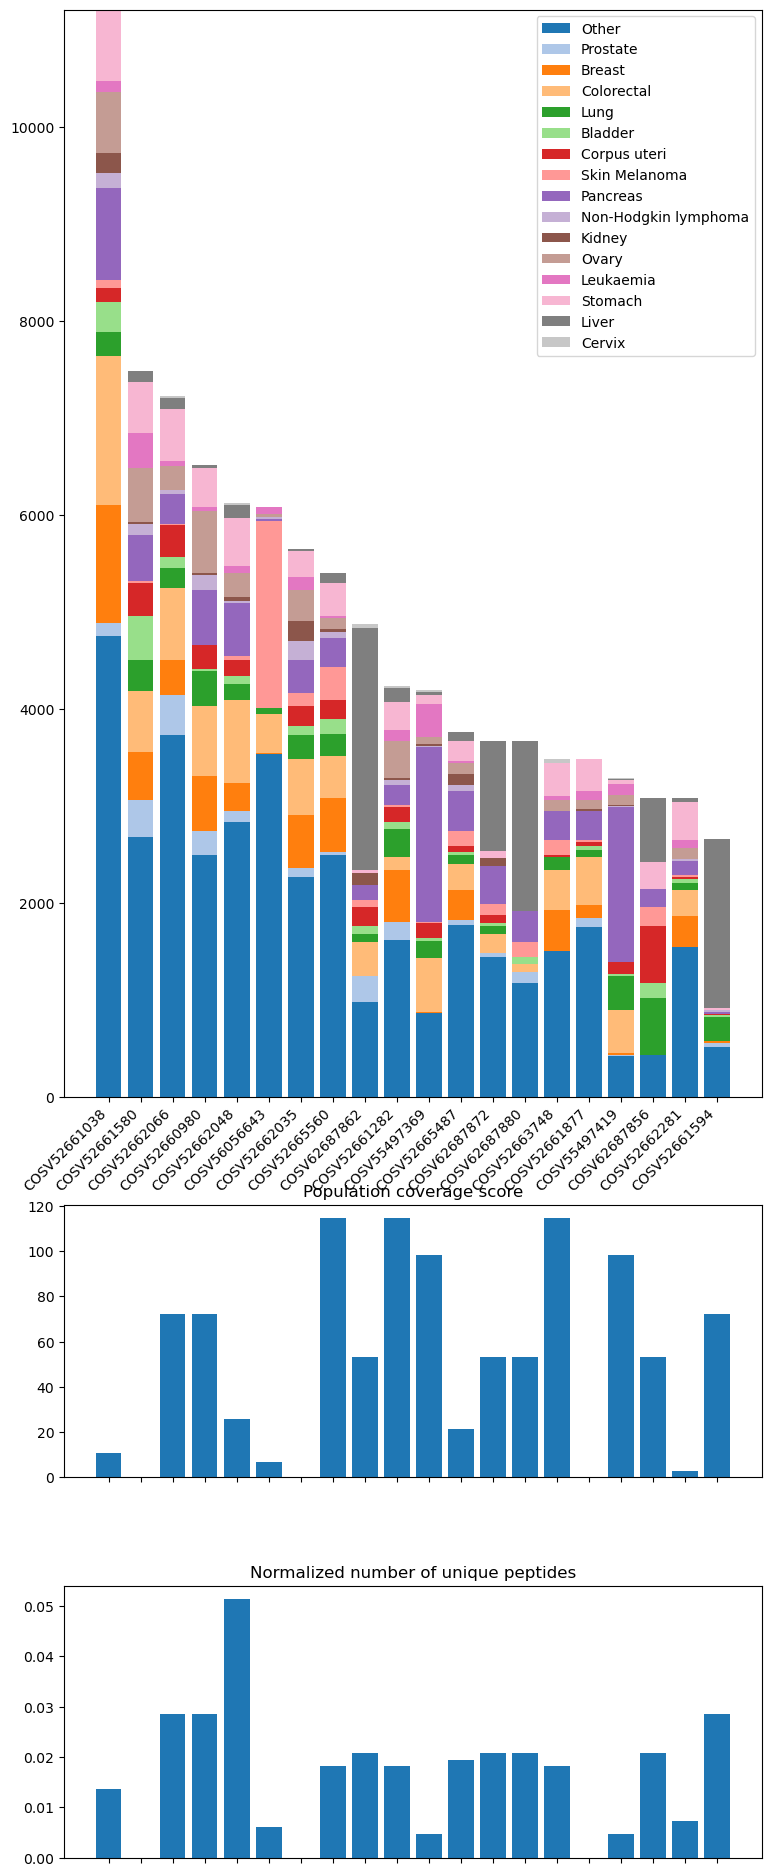

In [42]:
top20recurring_mut =    cosmic_somatics["GENOMIC_MUTATION_ID"]\
                        .value_counts()\
                        .sort("count", descending=True)\
                        .head(20)
top20_cosvid = cosmic_somatics.filter(pl.col("GENOMIC_MUTATION_ID").is_in(top20recurring_mut["GENOMIC_MUTATION_ID"]))
top20_coordinates = top20_cosvid\
                    .unique("GENOMIC_MUTATION_ID")\
                    .select("GENOMIC_MUTATION_ID",
                            "GENOME_START",
                            "GENOME_STOP",
                            "CHROMOSOME",
                            "MUTATION_AA",
                            "MUTATION_DESCRIPTION",
                            "MUTATION_CDS",
                            "GENE_SYMBOL")\
                    .with_columns(CHROMOSOME = pl.lit("chr") + pl.col("CHROMOSOME"))
justcontigs = contig_scaffold_list.filter(pl.col("gap_width") == 0)
top20_with_contigs = duckdb.sql(
    '''
    select * from top20_coordinates t, justcontigs c
    where
    t.CHROMOSOME == c.Chromosome
    and
    (
            ( t.GENOME_START between c.Gene_start and c.Gene_end )
        or  ( t.GENOME_STOP between c.Gene_start and c.Gene_end  )
    )
    '''
).pl()

top20_with_classif = top20_cosvid.join(cosmic_classification.with_columns(
                                PRIMARY_SITE = 
                                    pl.when(pl.col("PRIMARY_SITE")=="haematopoietic_and_lymphoid_tissue")\
                                    .then(
                                        pl.when(
                                        (pl.col("PRIMARY_HISTOLOGY")+pl.lit("_")+pl.col("HISTOLOGY_SUBTYPE_1"))\
                                        .is_in(['lymphoid_neoplasm_T_cell_prolymphocytic_leukaemia',
                                                'lymphoid_neoplasm_T_cell_large_granular_lymphocytic_leukaemia',
                                                'haematopoietic_neoplasm_polycythaemia_vera',
                                                'lymphoid_neoplasm_plasma_cell_myeloma',
                                                'lymphoid_neoplasm_NK_cell_leukaemia',
                                                'haematopoietic_neoplasm_myelofibrosis',
                                                'lymphoid_neoplasm_hairy_cell_leukaemia',
                                                'haematopoietic_neoplasm_chronic_neutrophilic_leukaemia',
                                                'haematopoietic_neoplasm_chronic_myelomonocytic_leukaemia',
                                                'haematopoietic_neoplasm_chronic_myeloid_leukaemia',
                                                'haematopoietic_neoplasm_blastic_plasmacytoid_dendritic_cell_neoplasm',
                                                'haematopoietic_neoplasm_blast_phase_chronic_myeloid_leukaemia',
                                                'lymphoid_neoplasm_B_cell_prolymphocytic_leukaemia',
                                                'lymphoid_neoplasm_adult_T_cell_lymphoma-leukaemia',
                                                'haematopoietic_neoplasm_acute_myeloid_leukaemia_therapy_related',
                                                'haematopoietic_neoplasm_acute_myeloid_leukaemia',
                                                'lymphoid_neoplasm_acute_lymphoblastic_T_cell_leukaemia',
                                                'lymphoid_neoplasm_acute_lymphoblastic_leukaemia',
                                                'lymphoid_neoplasm_acute_lymphoblastic_leukaemia',
                                                'haematopoietic_neoplasm_acute_lymphoblastic_leukaemia',
                                                'lymphoid_neoplasm_acute_lymphoblastic_B_cell_leukaemia',
                                                'haematopoietic_neoplasm_acute_leukaemia_of_ambiguous_lineage']
                                                )
                                            ).then(pl.lit("Leukaemia"))\
                                        .when((pl.col("PRIMARY_HISTOLOGY")+pl.lit("_")+pl.col("HISTOLOGY_SUBTYPE_1"))\
                                        .is_in(['lymphoid_neoplasm_primary_mediastinal_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_primary_central_nervous_system_lymphoma',
                                                'lymphoid_neoplasm_plasmacytoma',
                                                'lymphoid_neoplasm_peripheral_T_cell_lymphoma_unspecified',
                                                'lymphoid_neoplasm_NK-T_cell_lymphoma',
                                                'lymphoid_neoplasm_mycosis_fungoides-Sezary_syndrome',
                                                'lymphoid_neoplasm_marginal_zone_lymphoma',
                                                'lymphoid_neoplasm_marginal_zone_lymphoma',
                                                'lymphoid_neoplasm_mantle_cell_lymphoma',
                                                'lymphoid_neoplasm_mantle_cell_lymphoma',
                                                'lymphoid_neoplasm_malignant_histiocytosis',
                                                'lymphoid_neoplasm_gamma-delta_T_cell_lymphoma',
                                                'lymphoid_neoplasm_follicular_lymphoma',
                                                'lymphoid_neoplasm_follicular_lymphoma',
                                                'lymphoid_neoplasm_follicular_lymphoma',
                                                'lymphoid_neoplasm_follicular_lymphoma',
                                                'lymphoid_neoplasm_enteropathy_type_T_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_cutaneous_T_cell_lymphoma',
                                                'lymphoid_neoplasm_chronic_lymphocytic_leukaemia-small_lymphocytic_lymphoma',
                                                'lymphoid_neoplasm_Burkitt_lymphoma',
                                                'lymphoid_neoplasm_Burkitt_lymphoma',
                                                'lymphoid_neoplasm_Burkitt_lymphoma',
                                                'lymphoid_neoplasm_Burkitt_lymphoma',
                                                'lymphoid_neoplasm_Burkitt_lymphoma',
                                                'lymphoid_neoplasm_Burkitt_lymphoma',
                                                'lymphoid_neoplasm_breast_implant_associated_anaplastic_large_cell_lymphoma_invasive',
                                                'lymphoid_neoplasm_breast_implant_associated_anaplastic_large_cell_lymphoma_in_situ',
                                                'lymphoid_neoplasm_angioimmunoblastic_T_cell_lymphoma',
                                                'lymphoid_neoplasm_angioimmunoblastic_T_cell_lymphoma',
                                                'lymphoid_neoplasm_anaplastic_large_cell_lymphoma',
                                                'lymphoid_neoplasm_aggressive_epidermotropic_CD8+_T_cell_lymphoma']
                                                )
                                            ).then(pl.lit("Non-Hodgkin lymphoma"))\
                                        .otherwise(pl.lit("Other")))\
                                    .when(pl.col("PRIMARY_SITE")=="large_intestine")\
                                    .then(
                                        pl.when(pl.col("SITE_SUBTYPE_1").is_in(["colon","rectum"]))
                                        .then(pl.col("PRIMARY_SITE"))
                                        .otherwise(pl.lit("Other"))
                                    )
                                    .when(pl.col("PRIMARY_SITE")=="urinary_tract")\
                                    .then(
                                        pl.when(pl.col("SITE_SUBTYPE_1").is_in(["bladder"]))
                                        .then(pl.col("PRIMARY_SITE"))
                                        .otherwise(pl.lit("Other"))
                                    )
                                    .when(pl.col("PRIMARY_SITE")=="skin")\
                                    .then(
                                        pl.when(pl.col("PRIMARY_HISTOLOGY").is_in(["malignant_melanoma"]))
                                        .then(pl.col("PRIMARY_SITE"))
                                        .otherwise(pl.lit("Other"))
                                    )
                                    .when(pl.col("PRIMARY_SITE").is_in(["prostate",
                                                                        "breast",
                                                                        "lung",
                                                                        "large_intestine",
                                                                        "urinary_tract",
                                                                        "endometrium",
                                                                        "skin",
                                                                        "pancreas",
                                                                        "kidney",
                                                                        "ovary",
                                                                        "stomach",
                                                                        "cervix",
                                                                        "liver"]))
                                    .then(pl.col("PRIMARY_SITE"))
                                    .otherwise(pl.lit("Other"))
                                    ),
          on="COSMIC_PHENOTYPE_ID")
stacked_barplot_matrix =    top20_with_classif\
                            .group_by("GENOMIC_MUTATION_ID")\
                            .agg([pl.col("PRIMARY_SITE").value_counts()])\
                            .explode("PRIMARY_SITE")\
                            .unnest("PRIMARY_SITE")\
                            .pivot(values="count", columns="PRIMARY_SITE", index="GENOMIC_MUTATION_ID")\
                            .fill_null(0)
fixed_mutation_order = pl.Enum(top20recurring_mut["GENOMIC_MUTATION_ID"].to_list())
hotspot_score_3_axis_per_contig = pl.read_parquet(contig_hotspot_score_file)
fig = plt.figure(figsize=(9,12))
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42
plt.rcParams["svg.fonttype"] = "none"
fig = plt.figure(figsize=(9,24))
ax = plt.subplot(311)

bottom=np.zeros(20)
index = 0
for column in stacked_barplot_matrix.sort(pl.col("GENOMIC_MUTATION_ID").cast(fixed_mutation_order)).select("Other","prostate","breast", "large_intestine", "lung", "urinary_tract", "endometrium", "skin", "pancreas", "Non-Hodgkin lymphoma", "kidney", "ovary", "Leukaemia", "stomach", "liver", "cervix").iter_columns():
    p = ax.bar(fixed_mutation_order.categories, column.to_numpy(), bottom=bottom, label = column.name, color=tab20(index))
    bottom += column.to_numpy()
    index+=1

ax.legend(labels=["Other",
                  "Prostate",
                  "Breast",
                  "Colorectal",
                  "Lung",
                  "Bladder",
                  "Corpus uteri",
                  "Skin Melanoma",
                  "Pancreas",
                  "Non-Hodgkin lymphoma",
                  "Kidney",
                  "Ovary",
                  "Leukaemia",
                  "Stomach",
                  "Liver",
                  "Cervix"])
ax.set_xticks(range(fixed_mutation_order.categories.len()),ax.get_xticklabels(),rotation=45,ha='right')

ax2 = plt.subplot(312)
stats = stacked_barplot_matrix\
        .sort(pl.col("GENOMIC_MUTATION_ID")\
        .cast(fixed_mutation_order))\
        .join(
            top20_with_contigs,
            on="GENOMIC_MUTATION_ID",
            how="left")\
        .select("GENOMIC_MUTATION_ID","Id")\
        .join(
            hotspot_score_3_axis_per_contig,
            on="Id",
            how="left").fill_null(0)
ax2.bar(stats["GENOMIC_MUTATION_ID"], stats["popcov_but_sqrt"])
ax2.set_xticklabels([])
ax2.set_title("Population coverage score")
ax3 = plt.subplot(313)
ax3.bar(stats["GENOMIC_MUTATION_ID"], stats["normalized_unique_pep"])
ax3.set_xticklabels([])
ax3.set_title("Normalized number of unique peptides")
gridspec1 = ax2.get_gridspec()
gridspec1.set_height_ratios([4,1,1])
gridspec1.update()
gridspec2 = ax3.get_gridspec()
gridspec2.set_height_ratios([4,1,1])
gridspec2.update()
fig.savefig(fig6panelc)

# Panel A bottom half

/tmp/ipykernel_1136148/1161447935.py:163: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  stats = stacked_barplot_matrix\


<Figure size 900x1200 with 0 Axes>

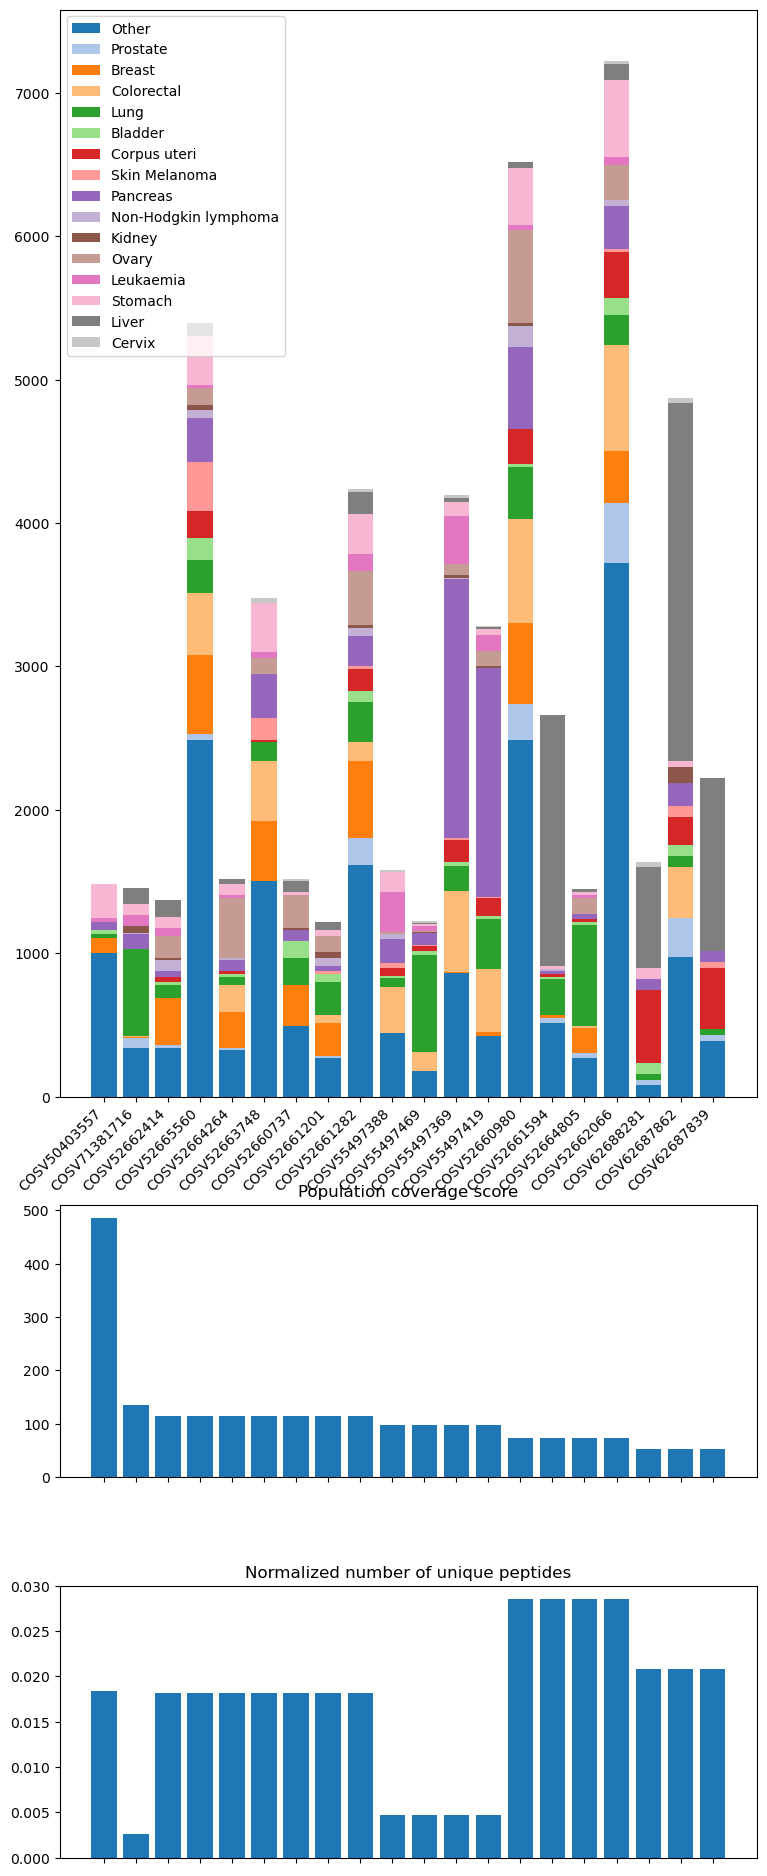

In [44]:
top50recurring_mut =    cosmic_somatics["GENOMIC_MUTATION_ID"]\
                        .value_counts()\
                        .sort("count", descending=True)\
                        .head(50)
top50_cosvid = cosmic_somatics.filter(pl.col("GENOMIC_MUTATION_ID").is_in(top50recurring_mut["GENOMIC_MUTATION_ID"]))
top50_coordinates = top50_cosvid\
                    .unique("GENOMIC_MUTATION_ID")\
                    .select("GENOMIC_MUTATION_ID",
                            "GENOME_START",
                            "GENOME_STOP",
                            "CHROMOSOME",
                            "MUTATION_AA",
                            "MUTATION_DESCRIPTION",
                            "MUTATION_CDS",
                            "GENE_SYMBOL")\
                    .with_columns(CHROMOSOME = pl.lit("chr") + pl.col("CHROMOSOME"))
top50_with_contigs = duckdb.sql(
    '''
    select * from top50_coordinates t, justcontigs c
    where
    t.CHROMOSOME == c.Chromosome
    and
    (
            ( t.GENOME_START between c.Gene_start and c.Gene_end )
        or  ( t.GENOME_STOP between c.Gene_start and c.Gene_end  )
    )
    '''
).pl()

top50_with_classif = top50_cosvid.join(cosmic_classification.with_columns(
                                PRIMARY_SITE = 
                                    pl.when(pl.col("PRIMARY_SITE")=="haematopoietic_and_lymphoid_tissue")\
                                    .then(
                                        pl.when(
                                        (pl.col("PRIMARY_HISTOLOGY")+pl.lit("_")+pl.col("HISTOLOGY_SUBTYPE_1"))\
                                        .is_in(['lymphoid_neoplasm_T_cell_prolymphocytic_leukaemia',
                                                'lymphoid_neoplasm_T_cell_large_granular_lymphocytic_leukaemia',
                                                'haematopoietic_neoplasm_polycythaemia_vera',
                                                'lymphoid_neoplasm_plasma_cell_myeloma',
                                                'lymphoid_neoplasm_NK_cell_leukaemia',
                                                'haematopoietic_neoplasm_myelofibrosis',
                                                'lymphoid_neoplasm_hairy_cell_leukaemia',
                                                'haematopoietic_neoplasm_chronic_neutrophilic_leukaemia',
                                                'haematopoietic_neoplasm_chronic_myelomonocytic_leukaemia',
                                                'haematopoietic_neoplasm_chronic_myeloid_leukaemia',
                                                'haematopoietic_neoplasm_blastic_plasmacytoid_dendritic_cell_neoplasm',
                                                'haematopoietic_neoplasm_blast_phase_chronic_myeloid_leukaemia',
                                                'lymphoid_neoplasm_B_cell_prolymphocytic_leukaemia',
                                                'lymphoid_neoplasm_adult_T_cell_lymphoma-leukaemia',
                                                'haematopoietic_neoplasm_acute_myeloid_leukaemia_therapy_related',
                                                'haematopoietic_neoplasm_acute_myeloid_leukaemia',
                                                'lymphoid_neoplasm_acute_lymphoblastic_T_cell_leukaemia',
                                                'lymphoid_neoplasm_acute_lymphoblastic_leukaemia',
                                                'lymphoid_neoplasm_acute_lymphoblastic_leukaemia',
                                                'haematopoietic_neoplasm_acute_lymphoblastic_leukaemia',
                                                'lymphoid_neoplasm_acute_lymphoblastic_B_cell_leukaemia',
                                                'haematopoietic_neoplasm_acute_leukaemia_of_ambiguous_lineage']
                                                )
                                            ).then(pl.lit("Leukaemia"))\
                                        .when((pl.col("PRIMARY_HISTOLOGY")+pl.lit("_")+pl.col("HISTOLOGY_SUBTYPE_1"))\
                                        .is_in(['lymphoid_neoplasm_primary_mediastinal_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_primary_central_nervous_system_lymphoma',
                                                'lymphoid_neoplasm_plasmacytoma',
                                                'lymphoid_neoplasm_peripheral_T_cell_lymphoma_unspecified',
                                                'lymphoid_neoplasm_NK-T_cell_lymphoma',
                                                'lymphoid_neoplasm_mycosis_fungoides-Sezary_syndrome',
                                                'lymphoid_neoplasm_marginal_zone_lymphoma',
                                                'lymphoid_neoplasm_marginal_zone_lymphoma',
                                                'lymphoid_neoplasm_mantle_cell_lymphoma',
                                                'lymphoid_neoplasm_mantle_cell_lymphoma',
                                                'lymphoid_neoplasm_malignant_histiocytosis',
                                                'lymphoid_neoplasm_gamma-delta_T_cell_lymphoma',
                                                'lymphoid_neoplasm_follicular_lymphoma',
                                                'lymphoid_neoplasm_follicular_lymphoma',
                                                'lymphoid_neoplasm_follicular_lymphoma',
                                                'lymphoid_neoplasm_follicular_lymphoma',
                                                'lymphoid_neoplasm_enteropathy_type_T_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_diffuse_large_B_cell_lymphoma',
                                                'lymphoid_neoplasm_cutaneous_T_cell_lymphoma',
                                                'lymphoid_neoplasm_chronic_lymphocytic_leukaemia-small_lymphocytic_lymphoma',
                                                'lymphoid_neoplasm_Burkitt_lymphoma',
                                                'lymphoid_neoplasm_Burkitt_lymphoma',
                                                'lymphoid_neoplasm_Burkitt_lymphoma',
                                                'lymphoid_neoplasm_Burkitt_lymphoma',
                                                'lymphoid_neoplasm_Burkitt_lymphoma',
                                                'lymphoid_neoplasm_Burkitt_lymphoma',
                                                'lymphoid_neoplasm_breast_implant_associated_anaplastic_large_cell_lymphoma_invasive',
                                                'lymphoid_neoplasm_breast_implant_associated_anaplastic_large_cell_lymphoma_in_situ',
                                                'lymphoid_neoplasm_angioimmunoblastic_T_cell_lymphoma',
                                                'lymphoid_neoplasm_angioimmunoblastic_T_cell_lymphoma',
                                                'lymphoid_neoplasm_anaplastic_large_cell_lymphoma',
                                                'lymphoid_neoplasm_aggressive_epidermotropic_CD8+_T_cell_lymphoma']
                                                )
                                            ).then(pl.lit("Non-Hodgkin lymphoma"))\
                                        .otherwise(pl.lit("Other")))\
                                    .when(pl.col("PRIMARY_SITE")=="large_intestine")\
                                    .then(
                                        pl.when(pl.col("SITE_SUBTYPE_1").is_in(["colon","rectum"]))
                                        .then(pl.col("PRIMARY_SITE"))
                                        .otherwise(pl.lit("Other"))
                                    )
                                    .when(pl.col("PRIMARY_SITE")=="urinary_tract")\
                                    .then(
                                        pl.when(pl.col("SITE_SUBTYPE_1").is_in(["bladder"]))
                                        .then(pl.col("PRIMARY_SITE"))
                                        .otherwise(pl.lit("Other"))
                                    )
                                    .when(pl.col("PRIMARY_SITE")=="skin")\
                                    .then(
                                        pl.when(pl.col("PRIMARY_HISTOLOGY").is_in(["malignant_melanoma"]))
                                        .then(pl.col("PRIMARY_SITE"))
                                        .otherwise(pl.lit("Other"))
                                    )
                                    .when(pl.col("PRIMARY_SITE").is_in(["prostate", "breast", "lung", "large_intestine", "urinary_tract", "endometrium", "skin", "pancreas", "kidney", "ovary", "stomach", "cervix", "liver"]))
                                    .then(pl.col("PRIMARY_SITE"))
                                    .otherwise(pl.lit("Other"))
                                    ),
          on="COSMIC_PHENOTYPE_ID")
stacked_barplot_matrix =    top50_with_classif\
                            .group_by("GENOMIC_MUTATION_ID")\
                            .agg([pl.col("PRIMARY_SITE").value_counts()])\
                            .explode("PRIMARY_SITE")\
                            .unnest("PRIMARY_SITE")\
                            .pivot(values="count", columns="PRIMARY_SITE", index="GENOMIC_MUTATION_ID")\
                            .fill_null(0)
fixed_mutation_order = pl.Enum(
    top50_with_contigs.join(
        hotspot_score_3_axis_per_contig.with_columns(
            popcovpep_idx = pl.col("unique_pep_idx") + pl.col("pop_cov_idx")
            ),
        on="Id")\
        .sort("pop_cov_idx")\
        .head(20)["GENOMIC_MUTATION_ID"].to_list()
        )
stacked_barplot_matrix = stacked_barplot_matrix.filter(pl.col("GENOMIC_MUTATION_ID").is_in(fixed_mutation_order.categories))
fig = plt.figure(figsize=(9,12))
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42
plt.rcParams["svg.fonttype"] = "none"
fig = plt.figure(figsize=(9,24))
ax = plt.subplot(311)

bottom = np.zeros(20)
index = 0
for column in stacked_barplot_matrix.sort(pl.col("GENOMIC_MUTATION_ID").cast(fixed_mutation_order)).select("Other","prostate","breast", "large_intestine", "lung", "urinary_tract", "endometrium", "skin", "pancreas", "Non-Hodgkin lymphoma", "kidney", "ovary", "Leukaemia", "stomach", "liver", "cervix").iter_columns():
    p = ax.bar(fixed_mutation_order.categories, column.to_numpy(), bottom=bottom, label = column.name, color=tab20(index))
    bottom += column.to_numpy()
    index+=1

ax.legend(labels=["Other","Prostate","Breast", "Colorectal", "Lung", "Bladder", "Corpus uteri", "Skin Melanoma", "Pancreas", "Non-Hodgkin lymphoma", "Kidney", "Ovary", "Leukaemia", "Stomach", "Liver", "Cervix"])
ax.set_xticks(range(fixed_mutation_order.categories.len()),ax.get_xticklabels(),rotation=45,ha='right')

ax2 = plt.subplot(312)
stats = stacked_barplot_matrix\
        .sort(pl.col("GENOMIC_MUTATION_ID")\
        .cast(fixed_mutation_order))\
        .join(
            top50_with_contigs,
            on="GENOMIC_MUTATION_ID",
            how="left")\
        .select("GENOMIC_MUTATION_ID","Id")\
        .join(hotspot_score_3_axis_per_contig, on="Id", how="left")\
        .fill_null(0)
ax2.bar(stats["GENOMIC_MUTATION_ID"], stats["popcov_but_sqrt"])
ax2.set_xticklabels([])
ax2.set_title("Population coverage score")
ax3 = plt.subplot(313)
ax3.bar(stats["GENOMIC_MUTATION_ID"], stats["normalized_unique_pep"])
ax3.set_xticklabels([])
ax3.set_title("Normalized number of unique peptides")
gridspec1 = ax2.get_gridspec()
gridspec1.set_height_ratios([4,1,1])
gridspec1.update()
gridspec2 = ax3.get_gridspec()
gridspec2.set_height_ratios([4,1,1])
gridspec2.update()
fig.savefig(fig6paneld)


# Panel B

There's one more mutation here that didn't end up in the figure. I don't remember which so I'm not removing it atm.

/tmp/ipykernel_1136148/731494222.py:20: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  motif_peptide_size = emilia_umap_with_ids\
/tmp/ipykernel_1136148/731494222.py:20: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  motif_peptide_size = emilia_umap_with_ids\


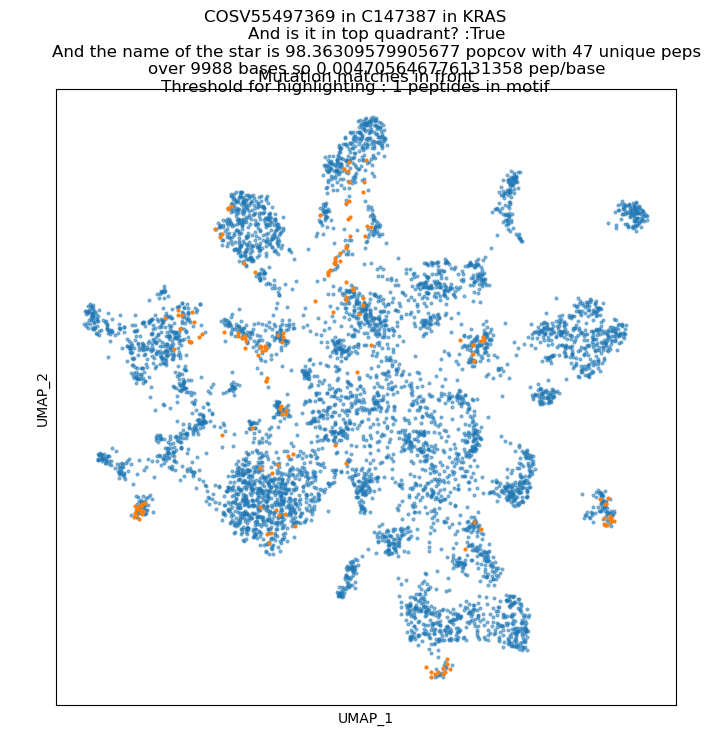

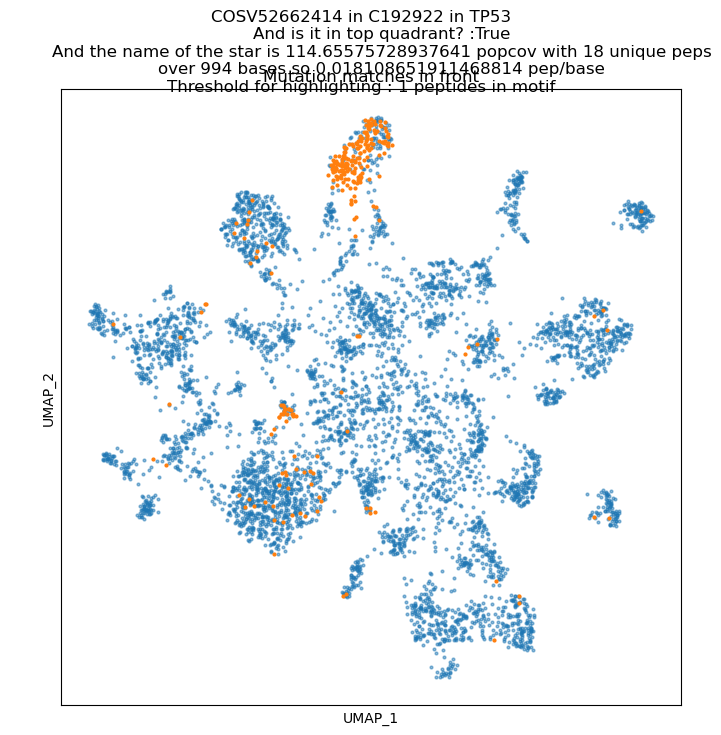

In [ ]:
t50tmpfile = temp_dir.joinpath("mutations_top50_with_boolean_tq_status.parquet")
contig_peptide_list = pl.read_csv(contig_peptide_list_file, separator='\t')
top50stats = top50_with_contigs.join(
        hotspot_score_3_axis_per_contig.with_columns(
            popcovpep_idx = pl.col("unique_pep_idx") + pl.col("pop_cov_idx")
            ),
        on="Id")\
        .sort("pop_cov_idx")
tq = pl.read_parquet(contig_hotspot_score_top_quadrant_file)
top50stats.with_columns(is_in_tq = pl.col("Id").is_in(tq["Id"])).write_parquet(t50tmpfile)
t50fromtq = pl.read_parquet(t50tmpfile)
t50fromtqwithpep = t50fromtq.join(contig_peptide_list, left_on="Contigs", right_on="contig")
def plot_motif_space_for_a_list_of_peptides2(list_of_peptides, match_color = 'tab:orange', mismatch_color= 'tab:blue', minimum_match = 1, title_header = ""):
    
    fig = plt.figure(figsize=(8,8))
    plt.rcParams["pdf.fonttype"] = 42
    plt.rcParams["ps.fonttype"] = 42
    plt.rcParams["svg.fonttype"] = "none"
    emilia_umap_with_ids = pl.read_parquet(main_samples_file_3)
    motif_peptide_size = emilia_umap_with_ids\
                                .explode(
                                    "Peptides"
                                ).group_by(
                                    "Id"
                                ).count().rename({"count":"motif_size"})
    matchcount_per_motif =  emilia_umap_with_ids\
                                .explode(
                                    "Peptides"
                                ).with_columns(
                                    pl.col("Peptides").is_in(list_of_peptides).cast(pl.Int64())
                                ).group_by(
                                    "Id"
                                ).sum(
                                ).select(
                                    pl.col("Id"), pl.col("Peptides").alias("Number_of_matches")
                                ).join(motif_peptide_size, on="Id")
    plot_material = emilia_umap_with_ids\
                        .join(matchcount_per_motif, on="Id")
    if minimum_match >= 1:
        fig.suptitle(f"{title_header}\nThreshold for highlighting : {minimum_match} peptides in motif")
        matches = plot_material.filter(pl.col("Number_of_matches")>=minimum_match)
        mismatches = plot_material.filter(pl.col("Number_of_matches")<minimum_match)
    elif 1.0 > minimum_match > 0.0:
        fig.suptitle(f"{title_header}\nThreshold for highlighting : {minimum_match * 100} % of peptides in motif")
        matches = plot_material.filter(pl.col("Number_of_matches")>=minimum_match * pl.col("motif_size"))
        mismatches = plot_material.filter(pl.col("Number_of_matches")<minimum_match * pl.col("motif_size"))
    else:
        return "That aint a correct minimal match numer or fraction"
         
    
    ax1 = plt.subplot(111)
    ax1.scatter(mismatches["x"], mismatches["y"], c=mismatch_color, s=4, alpha=0.5)
    ax1.scatter(matches["x"], matches["y"], c=match_color, s=4)
    ax1.set_title("Mutation matches in front")
    ax1.set_xlabel("UMAP_1")
    ax1.set_ylabel("UMAP_2")
    ax1.set_xticklabels("")
    ax1.set_yticklabels("")
    ax1.set_xticks([])
    ax1.set_yticks([])
    return fig

for row in t50fromtqwithpep.filter(pl.col("GENOMIC_MUTATION_ID").is_in(["COSV55497369","COSV52662414","COSV50403557"])).iter_rows(named=True):
    plot_motif_space_for_a_list_of_peptides2(
        row["pep_list"].split(","), 
        title_header=
        f'{row["GENOMIC_MUTATION_ID"]} in {row["Contigs"]} in {row["GENE_SYMBOL"]}\n\
        And is it in top quadrant? :{row["is_in_tq"]}\n\
        And the name of the star is {row["popcov_but_sqrt"]} popcov with {row["unique_peptides"]} unique peps\n\
        over {row["exon_length"]} bases so {row["normalized_unique_pep"]} pep/base')\
    .savefig(figures_gen_dir.joinpath(f'{row["GENOMIC_MUTATION_ID"]}.pdf'))

# Panel d

In [ ]:
mutcount_join_by_gene = mutations_in_contigs_from_top_15_cancers.group_by("GENE_SYMBOL").agg(
    mutations_visible = pl.col("GENOMIC_MUTATION_ID").unique().len()
).join(mutations_outside_contigs_from_top_15_cancers.group_by("GENE_SYMBOL").agg(
    mutations_not_presented = pl.col("GENOMIC_MUTATION_ID").unique().len()
), on=["GENE_SYMBOL"], how="outer")

In [ ]:
scatter_by_gene = mutcount_join_by_gene.with_columns(
                        GENE_SYMBOL = pl.when(pl.col("GENE_SYMBOL").is_not_null())\
                        .then(pl.col("GENE_SYMBOL"))\
                        .otherwise(pl.col("GENE_SYMBOL_right")))\
                    .fill_null(0)\
                    .with_columns(mutcount = pl.col("mutations_visible")+pl.col("mutations_not_presented"))\
                    .with_columns(percent_visible = pl.col("mutations_visible")/pl.col("mutcount"))

In [ ]:
scatter_by_gene_panel = scatter_by_gene.filter(pl.col("GENE_SYMBOL").is_in(panelgenes_but_with_gencode_columns["Hugo Symbol"]))

In [ ]:
normalized_scatter_by_gene_panel = scatter_by_gene_panel.join(
    panelgenes_but_with_gencode_columns,
    left_on="GENE_SYMBOL",
    right_on="Hugo Symbol").join(
        genestats, 
        on="gene_id")\
    .with_columns(
        exonlen = (pl.col("end") - pl.col("start"))*pl.col("exon_percentage"))\
    .with_columns(normalizedmut = pl.col("mutcount") / pl.col("exonlen"))

In [ ]:
mm=1/25.4
fig = plt.figure(figsize=(86.556*3*mm,49.734*3*mm))
ax.scatter(normalized_scatter_by_gene_panel["normalizedmut"], normalized_scatter_by_gene_panel["percent_visible"],s=1)
ax.vlines(normalized_scatter_by_gene_panel.sort("normalizedmut", descending=True)["normalizedmut"][math.floor(len(normalized_scatter_by_gene_panel)*0.2)],0,1, color="tab:red", label="20th percentile")
#ax.vlines(normalized_scatter_by_gene_panel.sort("normalizedmut", descending=True)["normalizedmut"][math.floor(len(normalized_scatter_by_gene_panel)*0.1)],0,1, color="tab:pink", label="10th percentile")
#ax.vlines(normalized_scatter_by_gene_panel["normalizedmut"].median(), 0, 1,color="tab:green", label="median")
#ax.vlines(normalized_scatter_by_gene_panel["normalizedmut"].mean(), 0, 1,color="tab:orange", label="mean")
#ax.legend()
#ax.set_title(f'Corr (speaman) :{normalized_scatter_by_gene_panel.select(corr = pl.corr(normalized_scatter_by_gene_panel["normalizedmut"], normalized_scatter_by_gene_panel["percent_visible"], method="spearman"))["corr"][0]}')
#ax2 = plt.subplot(222)
#ax2.set_ylim(ax.get_ylim())
#ax2.hist(normalized_scatter_by_gene_panel["percent_visible"], bins=25, orientation="horizontal", label=f'Not normal distribution')
#ax2.legend()
#ax3 = plt.subplot(223)
#ax3.set_xlim(ax.get_xlim())
#ax3.hist(normalized_scatter_by_gene_panel["normalizedmut"], bins=25, label=f'Not normal distribution')
#ax3.legend()
#ax3.invert_yaxis()
#ax.set_xscale("log")
fig.savefig("scatter_top_20_percent.pdf", dpi=100)

# Final Cleanup

This is to clean up and delete all additional files and directories created throughout the analysis.

**Do not run the second cell unless you want to end your work here or start over.**

In [ ]:
# This is a safety code

raise KeyboardInterrupt("Are you sure you want to run the cell below?")

In [ ]:
# Run this cell to do a clean-up

t50tmpfile.unlink()
panelgene_list_file.unlink()
temp_dir.joinpath("tq_stats/*").unlink()
temp_dir.joinpath("tq_exons/*").unlink()
temp_dir.joinpath("tq_nonexons/*").unlink()